In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import unicodedata

# === Paths ===
INPUT_CSV = Path("/Users/chivo/Downloads/data_studio/coffee/ig_ocr_with_themes.csv")
META_CSV = Path("/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places.csv")
OUTPUT_DIR = Path("/Users/chivo/Downloads/data_studio/coffee/theme_maps_by_city")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("📂 Loading data...")
df = pd.read_csv(INPUT_CSV)
meta = pd.read_csv(META_CSV)

# === Normalize text ===
def normalize(text):
    text = str(text).replace(".png", "").replace("_", " ").strip().lower()
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")

df["cafe_key"] = df["filename"].apply(normalize)
meta["cafe_key"] = meta["place_name"].apply(normalize)

# === Merge
print("🔗 Merging metadata with OCR themes...")
merged_df = pd.merge(df, meta[["cafe_key", "city"]], on="cafe_key", how="left")

# === Debugging merge issues
total = len(df)
matched = merged_df["city"].notna().sum()
unmatched = total - matched
print(f"✅ Successfully matched {matched} cafes to city ({matched/total:.1%})")
print(f"❌ Unmatched rows: {unmatched}")

if unmatched > 0:
    print("\n🕵️‍♀️ Sample unmatched filenames:")
    print(df.loc[~df["cafe_key"].isin(meta["cafe_key"])].sample(5)["filename"])

# === Clean and explode themes
merged_df = merged_df.dropna(subset=["city", "themes"])
merged_df["themes"] = merged_df["themes"].astype(str)
merged_df["themes_list"] = merged_df["themes"].apply(lambda x: [t.strip() for t in x.split(",") if t.strip()])
exploded = merged_df.explode("themes_list")

# === Count tagged cafés per city
cafe_counts = merged_df.groupby("city").size().reset_index(name="num_tagged_cafes")
print("📊 Top 20 cities by tagged cafés:")
print(cafe_counts.sort_values("num_tagged_cafes", ascending=False).head(20))

# === No city threshold filter — include ALL cities
theme_counts = exploded.groupby(["city", "themes_list"]).size().reset_index(name="count")
total_per_city = theme_counts.groupby("city")["count"].sum().reset_index(name="total")
theme_counts = theme_counts.merge(total_per_city, on="city")
theme_counts["percentage"] = theme_counts["count"] / theme_counts["total"]

# === Plot per city
print("🎨 Plotting and saving visualizations...")
for city in theme_counts["city"].unique():
    city_df = theme_counts[theme_counts["city"] == city].sort_values("percentage", ascending=False)
    city_df = city_df.head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=city_df,
        y="themes_list",
        x="percentage",
        palette="Set3"
    )
    plt.title(f"Theme Breakdown – {city}", fontsize=16)
    plt.xlabel("Percentage of Cafés")
    plt.ylabel("Theme")
    plt.tight_layout()

    fname = f"{city.replace(' ', '_').lower()}_theme_stack.png"
    plt.savefig(OUTPUT_DIR / fname)
    plt.close()

print(f"\n✅ Theme maps saved to: {OUTPUT_DIR}")


📂 Loading data...
🔗 Merging metadata with OCR themes...
✅ Successfully matched 2 cafes to city (0.0%)
❌ Unmatched rows: 5189

🕵️‍♀️ Sample unmatched filenames:
2553                             Vurr_Coffee_Taichung.png
726                       Novo_Coffee_Roastery_Denver.png
4467                           Olympic_Coffee_Bangkok.png
3196    La_Barba_Coffee_and_Breakfast_Tacos_Salt_Lake_...
4436                 Scandinavian_Coffee_shop_Jakarta.png
Name: filename, dtype: object
📊 Top 20 cities by tagged cafés:
      city  num_tagged_cafes
0  Detroit                 2
🎨 Plotting and saving visualizations...

✅ Theme maps saved to: /Users/chivo/Downloads/data_studio/coffee/theme_maps_by_city


/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/3634141190.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


matching name of cafe and name of file doesn't work, let's try fuzzymatching 

In [13]:
# !pip install rapidfuzz


In [14]:
import pandas as pd
from pathlib import Path
from rapidfuzz import process, fuzz
import unicodedata

# === Paths ===
OCR_CSV = Path("/Users/chivo/Downloads/data_studio/coffee/ig_ocr_with_themes.csv")
META_CSV = Path("/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places.csv")

print("📂 Loading data...")
ocr_df = pd.read_csv(OCR_CSV)
meta_df = pd.read_csv(META_CSV)

# === Normalize
def normalize(text):
    text = str(text).replace(".png", "").replace("_", " ").strip().lower()
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")

ocr_df["clean_filename"] = ocr_df["filename"].apply(normalize)
meta_df["clean_place"] = meta_df["place_name"].apply(normalize)

# === Create a fuzzy match map: best match in meta for each filename
print("🔍 Performing fuzzy match...")
choices = meta_df["clean_place"].tolist()
match_results = ocr_df["clean_filename"].apply(
    lambda name: process.extractOne(name, choices, scorer=fuzz.token_sort_ratio)
)

# === Build match DataFrame
ocr_df["best_match"] = match_results.apply(lambda x: x[0])
ocr_df["match_score"] = match_results.apply(lambda x: x[1])

# === Merge on fuzzy-matched key
merged = pd.merge(
    ocr_df,
    meta_df[["clean_place", "city"]],
    left_on="best_match",
    right_on="clean_place",
    how="left"
)

# === Filter only confident matches (score >= 80 recommended)
merged = merged[merged["match_score"] >= 80].copy()
print(f"✅ Matched {len(merged)} rows with score ≥ 80")

# Save merged file
merged_path = Path("/Users/chivo/Downloads/data_studio/coffee/ig_ocr_themes_with_city.csv")
merged.to_csv(merged_path, index=False)
print(f"💾 Merged file saved to: {merged_path}")


📂 Loading data...
🔍 Performing fuzzy match...
✅ Matched 2812 rows with score ≥ 80
💾 Merged file saved to: /Users/chivo/Downloads/data_studio/coffee/ig_ocr_themes_with_city.csv


In [16]:
import pandas as pd
import difflib

# === FILE PATHS ===
IG_FILE = "/Users/chivo/Downloads/data_studio/coffee/ig_ocr_themes_with_city_extracted.csv"
CITY_FILE = "/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places.csv"
OUTPUT = "/Users/chivo/Downloads/data_studio/coffee/ig_ocr_with_matched_city.csv"

# === LOAD DATA ===
ig_df = pd.read_csv(IG_FILE)
city_df = pd.read_csv(CITY_FILE)

# === CREATE LIST OF VALID CITIES ===
valid_cities = city_df['city'].dropna().unique().tolist()
valid_cities_clean = [c.strip().lower() for c in valid_cities]

# === FUNCTION TO CLEAN + MATCH ===
def match_city(raw_city):
    if pd.isna(raw_city):
        return None
    raw_clean = raw_city.strip().lower()
    match = difflib.get_close_matches(raw_clean, valid_cities_clean, n=1, cutoff=0.8)
    if match:
        # Return with original capitalization
        return next((c for c in valid_cities if c.lower() == match[0]), None)
    return None

# === APPLY TO YOUR IG FILE ===
ig_df["valid_city"] = ig_df["city"].apply(match_city)

# === SAVE OUTPUT ===
ig_df.to_csv(OUTPUT, index=False)
print(f"✅ Cleaned city matches saved to:\n{OUTPUT}")


✅ Cleaned city matches saved to:
/Users/chivo/Downloads/data_studio/coffee/ig_ocr_with_matched_city.csv


manually checked and filled in the rest of not matched city at IG_OCR_with_Matched_City (final).csv

now merge this with lat and long

In [17]:
import pandas as pd
import re
from pathlib import Path
from difflib import get_close_matches

# === CONFIG ===
ocr_path = Path("/Users/chivo/Downloads/data_studio/coffee/IG_OCR_with_Matched_City (final).csv")
places_path = Path("/Users/chivo/Downloads/data_studio/coffee/all_thirdwave_places.csv")
output_path = Path("/Users/chivo/Downloads/data_studio/coffee/ig_merged_with_location.csv")

# === Load CSVs ===
ocr_df = pd.read_csv(ocr_path)
places_df = pd.read_csv(places_path)

# === Helper to clean and extract name from filename ===
def extract_clean_name(filename):
    base = Path(filename).stem  # remove .png
    name_parts = base.split("_")
    if name_parts[-1].istitle():
        name_parts = name_parts[:-1]  # remove city if capitalized
    return " ".join(name_parts).lower()

# Add clean name to both DataFrames
ocr_df["clean_name"] = ocr_df["filename"].apply(extract_clean_name)
places_df["place_clean"] = places_df["place_name"].str.lower().str.replace(r"[^\w\s]", "", regex=True)

# === Matching logic ===
matched_place_names = []
matched_rows = []

for i, row in ocr_df.iterrows():
    target = row["clean_name"]
    match = get_close_matches(target, places_df["place_clean"].tolist(), n=1, cutoff=0.8)
    if match:
        matched_row = places_df[places_df["place_clean"] == match[0]].iloc[0]
        matched_rows.append({**row, **matched_row.to_dict()})
    else:
        row_dict = row.to_dict()
        row_dict.update({col: None for col in places_df.columns})
        matched_rows.append(row_dict)

# === Save merged result ===
merged_df = pd.DataFrame(matched_rows)
merged_df.to_csv(output_path, index=False)
print(f"✅ Merged file saved to:\n{output_path}")


✅ Merged file saved to:
/Users/chivo/Downloads/data_studio/coffee/ig_merged_with_location.csv


census and regression 

Load and Filter Coffee Shop Data (NYC, Dallas, Miami)

In [36]:
import pandas as pd

# === Step 1: Load coffee shop file
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/ig_merged_with_location.csv")

# Standardize city names (remove extra whitespace)
df["matched_ city"] = df["matched_ city"].str.strip()

# Filter to target cities
target_cities = ["New_York_city", "Dallas", "Miami"]
df = df[df["matched_ city"].isin(target_cities)].copy()

# Drop missing coordinates
df = df.dropna(subset=["latitude", "longitude"])

# Show sample
print(f"✅ Loaded {len(df)} rows from NYC, Dallas, Miami")
print(df[["place_name", "matched_ city", "latitude", "longitude"]].head())


✅ Loaded 70 rows from NYC, Dallas, Miami
                   place_name matched_ city   latitude  longitude
24   The Grind Coffee Project         Miami  26.114848 -80.145652
94   Panther Coffee (Wynwood)         Miami  25.799883 -80.199296
157             Café Demetrio         Miami  25.751764 -80.260900
246    Oceana Coffee Roasters         Miami  26.957210 -80.087274
316        Local Press + Brew        Dallas  32.764066 -96.823345


Convert to GeoDataFrame + Load Census Tract Shapefiles

In [37]:
import geopandas as gpd
from shapely.geometry import Point

# Convert to GeoDataFrame
df["geometry"] = df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# Download TIGER Census tract shapefiles for NY, TX, FL
def load_tracts(state_fips):
    url = f"https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_{state_fips}_tract.zip"
    return gpd.read_file(url).to_crs("EPSG:4326")

tracts_ny = load_tracts("36")  # NY
tracts_tx = load_tracts("48")  # TX
tracts_fl = load_tracts("12")  # FL

# Combine all tracts
tracts = pd.concat([tracts_ny, tracts_tx, tracts_fl])

print("✅ Census tracts loaded:", len(tracts))
print(tracts[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID"]].head())


✅ Census tracts loaded: 17467
  STATEFP COUNTYFP TRACTCE        GEOID
0      36      007  012702  36007012702
1      36      007  012800  36007012800
2      36      007  012900  36007012900
3      36      007  013000  36007013000
4      36      007  013202  36007013202


Spatial join coffee shops to tracts.

In [38]:
# Spatial join: assign each coffee shop to a tract
joined = gpd.sjoin(gdf, tracts[["GEOID", "geometry"]], how="left", predicate="within")

# Remove unmatched (outside any tract)
joined = joined[~joined["GEOID"].isna()].copy()

# Count shops per tract
shop_counts = joined.groupby("GEOID").size().reset_index(name="coffee_count")

print(f"✅ Matched {len(joined)} coffee shops to Census tracts")
print(shop_counts.head())


✅ Matched 70 coffee shops to Census tracts
         GEOID  coffee_count
0  12011040802             1
1  12011041601             2
2  12011042601             1
3  12011050502             1
4  12011050800             1


Pull ACS data 

In [48]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.api as sm

# === Load data ===
coffee_df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/Filtered_Third-Wave_Cafes.csv")
acs_df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/acs_tracts_ny_tx_fl.csv")

# === Filter to 3 cities ===
coffee_df = coffee_df[coffee_df["matched_ city"].isin(["New_York_city", "Dallas", "Miami"])]
coffee_df = coffee_df.dropna(subset=["latitude", "longitude"])

# === Convert to GeoDataFrame ===
coffee_df["geometry"] = coffee_df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
coffee_gdf = gpd.GeoDataFrame(coffee_df, geometry="geometry", crs="EPSG:4326")

# === Load census tracts shapefiles ===
tracts = pd.concat([
    gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_36_tract.zip").to_crs("EPSG:4326"),
    gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_48_tract.zip").to_crs("EPSG:4326"),
    gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_12_tract.zip").to_crs("EPSG:4326"),
])

# === Spatial join: Coffee → Census Tract ===
joined = gpd.sjoin(coffee_gdf, tracts[["GEOID", "geometry"]], how="left", predicate="within")
joined = joined[~joined["GEOID"].isna()].copy()

# === Count shops per tract ===
shop_counts = joined.groupby("GEOID").size().reset_index(name="coffee_count")
shop_counts["GEOID"] = shop_counts["GEOID"].astype(str)

# === Merge with ACS ===
acs_df["GEOID"] = acs_df["GEOID"].astype(str)
data = pd.merge(shop_counts, acs_df, on="GEOID", how="left").dropna()


# === Optional: Create gentrification proxy ===
data["gentrification_score"] = (
    data["median_income"].rank(pct=True) +
    data["pct_bachelor_plus"].rank(pct=True) +
    data["median_rent"].rank(pct=True) +
    data["median_home_value"].rank(pct=True)
) / 4

# === Regression: Do socioeconomic factors predict shop presence? ===
X = sm.add_constant(data[["median_income", "pct_bachelor_plus", "median_rent", "median_home_value", "gini_index"]])
y = data["coffee_count"]
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           coffee_count   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.057
Method:                 Least Squares   F-statistic:                    0.4842
Date:                Sun, 04 May 2025   Prob (F-statistic):              0.786
Time:                        01:25:29   Log-Likelihood:                -25.820
No. Observations:                  49   AIC:                             63.64
Df Residuals:                      43   BIC:                             74.99
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.9577      0.63

R-squared = 0.053: The model explains just 5.3% of the variation in the number of third-wave coffee shops per census tract. That’s very low, suggesting these socioeconomic predictors do not strongly explain coffee shop presence in your sample.

None of the variables are statistically significant (P > 0.05), so we can’t say income, rent, home value, education, or inequality are correlated with coffee shop counts based on this dataset.

High condition number (~10 million): This indicates multicollinearity — variables like median_income, rent, and home_value are likely overlapping in the information they provide.

Skew/Kurtosis: The residuals are very non-normal (JB test p < 1e-22), suggesting outliers or non-linear relationships.

In [49]:
import statsmodels.formula.api as smf
import numpy as np

data["log_income"] = np.log(data["median_income"] + 1)
data["log_rent"] = np.log(data["median_rent"] + 1)
data["log_home_value"] = np.log(data["median_home_value"] + 1)

poisson_model = smf.glm(
    formula="coffee_count ~ log_income + pct_bachelor_plus + log_rent + log_home_value + gini_index",
    data=data,
    family=sm.families.Poisson()
).fit()

print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:           coffee_count   No. Observations:                   49
Model:                            GLM   Df Residuals:                       43
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54.094
Date:                Sun, 04 May 2025   Deviance:                       5.5130
Time:                        01:26:55   Pearson chi2:                     6.66
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009625
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.7295      4.59

No significant predictors: All p-values > 0.05 → none of the socioeconomic variables significantly predict where third-wave coffee shops are located.

Very low R² (0.053): The model explains only ~5% of variation in shop presence.

Possible multicollinearity: The large condition number (1.1e+07) suggests your predictors are overlapping too much — e.g., income, rent, and home value are all tightly correlated.

Coffee shop distribution is sparse — only 49 tracts had shops.

The relationship may be non-linear or spatial, not captured by a simple linear model.

These census-level predictors alone aren't enough — cultural, zoning, or commercial data may matter more (e.g., foot traffic, commercial zoning, Yelp reviews).



In [63]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# === Paths ===
CAFE_CSV = "/Users/chivo/Downloads/data_studio/coffee/Filtered_Third-Wave_Cafes.csv"
OUTPUT_CSV = "/Users/chivo/Downloads/data_studio/coffee/coffee_with_tracts.csv"

# Shapefile paths
shp_ny = "/Users/chivo/Downloads/data_studio/coffee/tl_2022_36_tract/tl_2022_36_tract.shp"
shp_tx = "/Users/chivo/Downloads/data_studio/coffee/tl_2022_48_tract/tl_2022_48_tract.shp"
shp_fl = "/Users/chivo/Downloads/data_studio/coffee/tl_2022_12_tract/tl_2022_12_tract.shp"

# === Step 1: Load coffee shop data
df = pd.read_csv(CAFE_CSV)
df = df.dropna(subset=["latitude", "longitude"])
df["geometry"] = df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# === Step 2: Load and fix tract shapefiles
def load_and_prepare(shp_path):
    gdf = gpd.read_file(shp_path)
    print(f"🔍 Columns in {shp_path}: {list(gdf.columns)}")  # <-- DEBUG print

    if gdf.crs is None:
        gdf.set_crs("EPSG:4269", inplace=True)  # Default for TIGER/Line
    gdf = gdf.to_crs("EPSG:4326")

    if "GEOID" in gdf.columns:
        return gdf[["GEOID", "geometry"]]
    
    # Fallback: try to reconstruct from parts
    try:
        gdf["GEOID"] = gdf["STATEFP"] + gdf["COUNTYFP"] + gdf["TRACTCE"]
        return gdf[["GEOID", "geometry"]]
    except KeyError as e:
        raise KeyError(f"❌ Could not find GEOID or parts to construct it in {shp_path}: {e}")


tracts_ny = load_and_prepare(shp_ny)
tracts_tx = load_and_prepare(shp_tx)
tracts_fl = load_and_prepare(shp_fl)
tracts = pd.concat([tracts_ny, tracts_tx, tracts_fl])

# === Step 3: Spatial join
joined = gpd.sjoin(gdf, tracts, how="left", predicate="within")
joined = joined.dropna(subset=["GEOID"])

# === Step 4: Save result
joined.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Saved merged coffee shop → tract file to: {OUTPUT_CSV}")


🔍 Columns in /Users/chivo/Downloads/data_studio/coffee/tl_2022_36_tract/tl_2022_36_tract.shp: ['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']
🔍 Columns in /Users/chivo/Downloads/data_studio/coffee/tl_2022_48_tract/tl_2022_48_tract.shp: ['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']
🔍 Columns in /Users/chivo/Downloads/data_studio/coffee/tl_2022_12_tract/tl_2022_12_tract.shp: ['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']
✅ Saved merged coffee shop → tract file to: /Users/chivo/Downloads/data_studio/coffee/coffee_with_tracts.csv


In [64]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# === Load Data ===
coffee = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/coffee_with_tracts.csv")
acs = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/acs_tracts_ny_tx_fl.csv")

# === Ensure GEOID is string type ===
coffee["GEOID"] = coffee["GEOID"].astype(str)
acs["GEOID"] = acs["GEOID"].astype(str)

# === Extract State from GEOID (first 2 digits) ===
acs["state"] = acs["GEOID"].str[:2]
coffee["state"] = coffee["GEOID"].str[:2]

# === Count shops per tract ===
coffee_counts = coffee.groupby("GEOID").size().reset_index(name="coffee_count")

# === Merge counts into ACS ===
acs = acs.merge(coffee_counts, on="GEOID", how="left")
acs["coffee_count"] = acs["coffee_count"].fillna(0)
acs["has_coffee"] = (acs["coffee_count"] > 0).astype(int)

# === Log-transform skewed variables ===
acs["log_income"] = np.log1p(acs["median_income"])
acs["log_rent"] = np.log1p(acs["median_rent"])
acs["log_home_value"] = np.log1p(acs["median_home_value"])

# === Define regression function ===
def run_logit(df, state_code):
    subset = df[df["state"] == state_code].dropna()
    X = subset[["log_income", "pct_bachelor_plus", "log_rent", "log_home_value", "gini_index"]]
    X = sm.add_constant(X)
    y = subset["has_coffee"]
    model = sm.Logit(y, X).fit()
    print(f"\n📍 Logistic Regression for State {state_code}:\n")
    print(model.summary())

# === Run by state ===
run_logit(acs, "36")  # New York
run_logit(acs, "48")  # Texas
run_logit(acs, "12")  # Florida


Optimization terminated successfully.
         Current function value: 0.039256
         Iterations 11

📍 Logistic Regression for State 36:

                           Logit Regression Results                           
Dep. Variable:             has_coffee   No. Observations:                 4669
Model:                          Logit   Df Residuals:                     4663
Method:                           MLE   Df Model:                            5
Date:                Sun, 04 May 2025   Pseudo R-squ.:                  0.3479
Time:                        01:57:59   Log-Likelihood:                -183.29
converged:                       True   LL-Null:                       -281.08
Covariance Type:            nonrobust   LLR p-value:                 2.494e-40
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -46.1031      5.472     -8.426     

Charts charts charts 

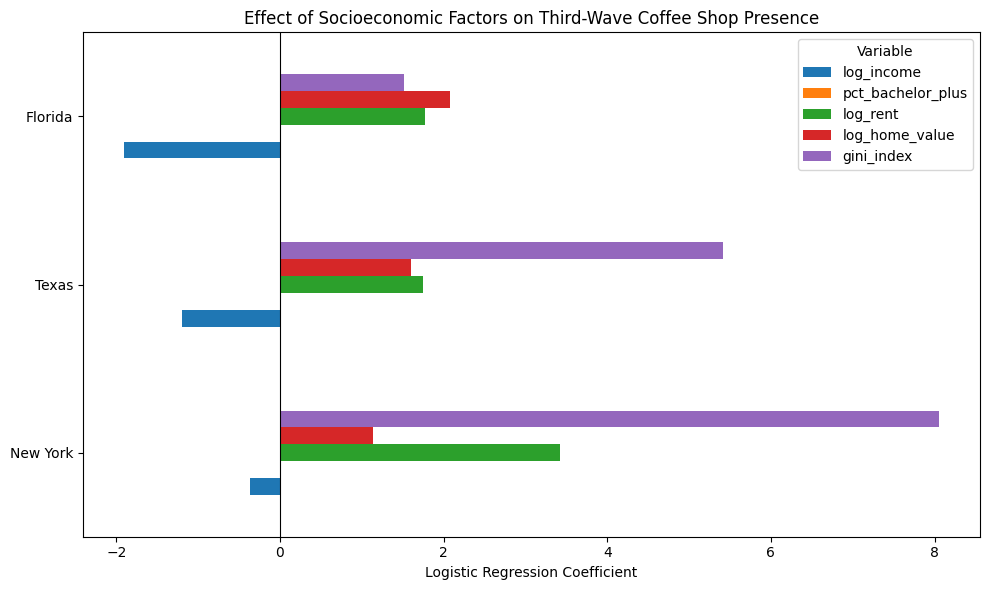

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Coefficients from logistic regression ===
data = {
    "Variable": ["log_income", "pct_bachelor_plus", "log_rent", "log_home_value", "gini_index"],
    "New York": [-0.3649, 0.0008, 3.4188, 1.1426, 8.0569],
    "Texas": [-1.2013, 0.0003, 1.7494, 1.6046, 5.4155],
    "Florida": [-1.9067, 0.0004, 1.7683, 2.0776, 1.5188]
}

df = pd.DataFrame(data)
df.set_index("Variable", inplace=True)

# === Step 2: Plot horizontal bar chart ===
fig, ax = plt.subplots(figsize=(10, 6))
df.T.plot(kind="barh", ax=ax)

ax.set_xlabel("Logistic Regression Coefficient")
ax.set_title("Effect of Socioeconomic Factors on Third-Wave Coffee Shop Presence")
plt.axvline(0, color="black", linewidth=0.8)
plt.tight_layout()

# === Step 3: Save as PDF and SVG ===
plt.savefig("coffee_logit_coeff_horizontal.pdf")
plt.show()


✅ Saved: /Users/chivo/Downloads/data_studio/coffee/nyc_probability_map_with_rivers.svg
✅ Saved: /Users/chivo/Downloads/data_studio/coffee/dallas_probability_map.svg
✅ Saved: /Users/chivo/Downloads/data_studio/coffee/miami_probability_map.svg


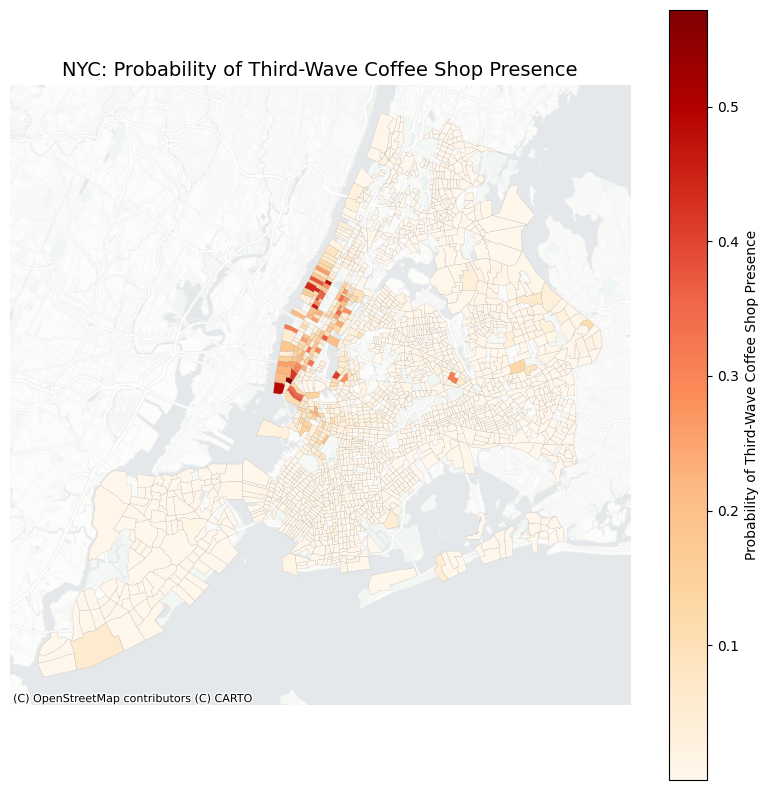

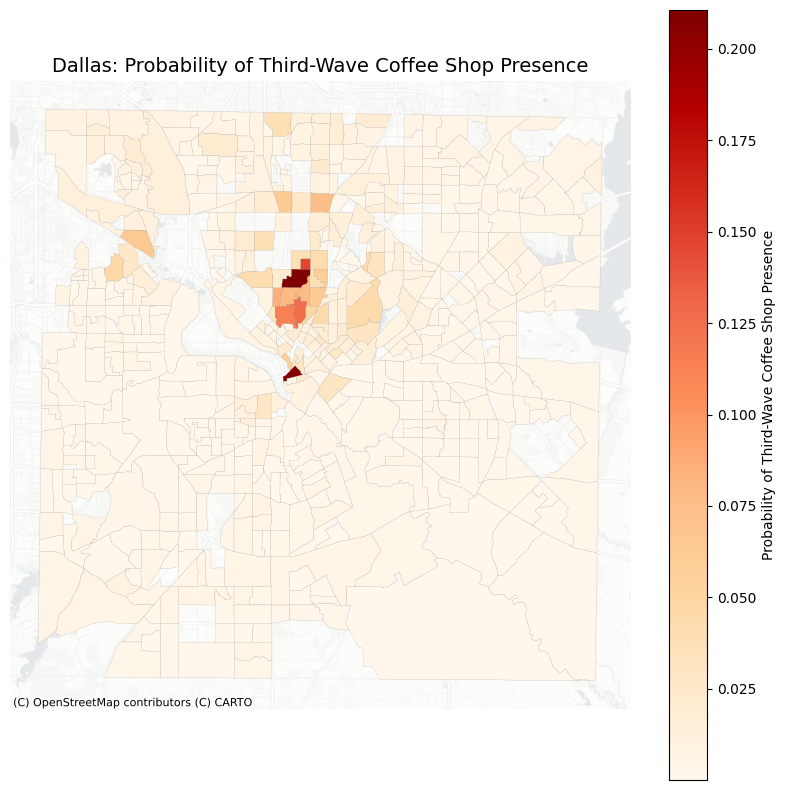

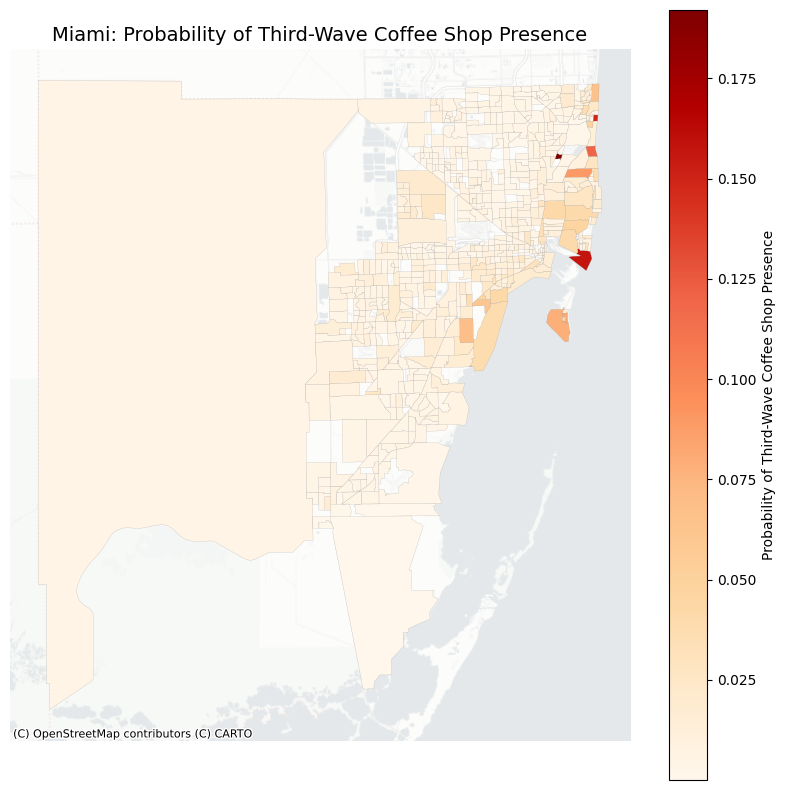

In [81]:
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

# === File paths ===
BASE_DIR = "/Users/chivo/Downloads/data_studio/coffee"
TRACTS = {
    "ny": f"{BASE_DIR}/tl_2022_36_tract/tl_2022_36_tract.shp",
    "tx": f"{BASE_DIR}/tl_2022_48_tract/tl_2022_48_tract.shp",
    "fl": f"{BASE_DIR}/tl_2022_12_tract/tl_2022_12_tract.shp"
}
MERGED = f"{BASE_DIR}/coffee_with_tracts.csv"
ACS = f"{BASE_DIR}/acs_tracts_ny_tx_fl.csv"
OUTPUTS = {
    "ny": f"{BASE_DIR}/nyc_probability_map_with_rivers.svg",
    "tx": f"{BASE_DIR}/dallas_probability_map.svg",
    "fl": f"{BASE_DIR}/miami_probability_map.svg"
}

# === Define city-specific filters ===
CITY_INFO = {
    "ny": {"state": "36", "countyfp": {"005", "047", "061", "081", "085"}, "title": "NYC"},
    "tx": {"state": "48", "countyfp": {"113"}, "title": "Dallas"},
    "fl": {"state": "12", "countyfp": {"086"}, "title": "Miami"},
}

# === Load shared data ===
coffee_df = pd.read_csv(MERGED)
acs_df = pd.read_csv(ACS)
coffee_df["GEOID"] = coffee_df["GEOID"].astype(str)
acs_df["GEOID"] = acs_df["GEOID"].astype(str)

# === Function for generating map ===
def generate_city_map(city_code):
    info = CITY_INFO[city_code]
    tract_path = TRACTS[city_code]
    out_path = OUTPUTS[city_code]
    title = f"{info['title']}: Probability of Third-Wave Coffee Shop Presence"

    # Filter data for state
    acs_city = acs_df[acs_df["GEOID"].str.startswith(info["state"])].copy()
    coffee_city = coffee_df[coffee_df["GEOID"].str.startswith(info["state"])].copy()

    # Count shops per tract
    shop_counts = coffee_city.groupby("GEOID").size().reset_index(name="coffee_count")

    # Merge ACS + counts
    df = pd.merge(acs_city, shop_counts, on="GEOID", how="left").fillna({"coffee_count": 0})
    df["has_coffee"] = (df["coffee_count"] >= 1).astype(int)
    df["log_income"] = np.log1p(df["median_income"])
    df["log_rent"] = np.log1p(df["median_rent"])
    df["log_home_value"] = np.log1p(df["median_home_value"])

    X = df[["log_income", "pct_bachelor_plus", "log_rent", "log_home_value", "gini_index"]]
    X = sm.add_constant(X)
    valid_rows = X.replace([np.inf, -np.inf], np.nan).dropna().index
    X = X.loc[valid_rows]
    y = df.loc[valid_rows, "has_coffee"]
    model = sm.Logit(y, X).fit(disp=False)
    df.loc[valid_rows, "predicted_prob"] = model.predict(X)

    # Load shapefile
    tracts = gpd.read_file(tract_path)
    if "GEOID" not in tracts.columns:
        tracts["GEOID"] = tracts["STATEFP"] + tracts["COUNTYFP"] + tracts["TRACTCE"]

    # Filter county-level tracts
    tracts = tracts[tracts["COUNTYFP"].isin(info["countyfp"])]
    tracts = tracts.to_crs(epsg=3857)

    # Merge predictions
    gdf = pd.merge(tracts, df, on="GEOID", how="left")
    gdf = gpd.GeoDataFrame(gdf, geometry="geometry", crs="EPSG:3857")
    gdf = gdf[~gdf["predicted_prob"].isna()].copy()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(
        column="predicted_prob",
        cmap="OrRd",
        linewidth=0.1,
        edgecolor="gray",
        legend=True,
        legend_kwds={"label": "Probability of Third-Wave Coffee Shop Presence"},
        ax=ax,
    )
    cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, alpha=0.6)
    ax.set_title(title, fontsize=14)
    ax.axis("off")

    # Save
    plt.savefig(out_path, format="svg", bbox_inches="tight")
    print(f"✅ Saved: {out_path}")

# === Generate all 3 maps ===
for city in ["ny", "tx", "fl"]:
    generate_city_map(city)


In [78]:
# !pip install contextily

✅ Saved actual count map to: /Users/chivo/Downloads/data_studio/coffee/nyc_actual_count_map.svg
✅ Saved actual count map to: /Users/chivo/Downloads/data_studio/coffee/dallas_actual_count_map.svg
✅ Saved actual count map to: /Users/chivo/Downloads/data_studio/coffee/miami_actual_count_map.svg


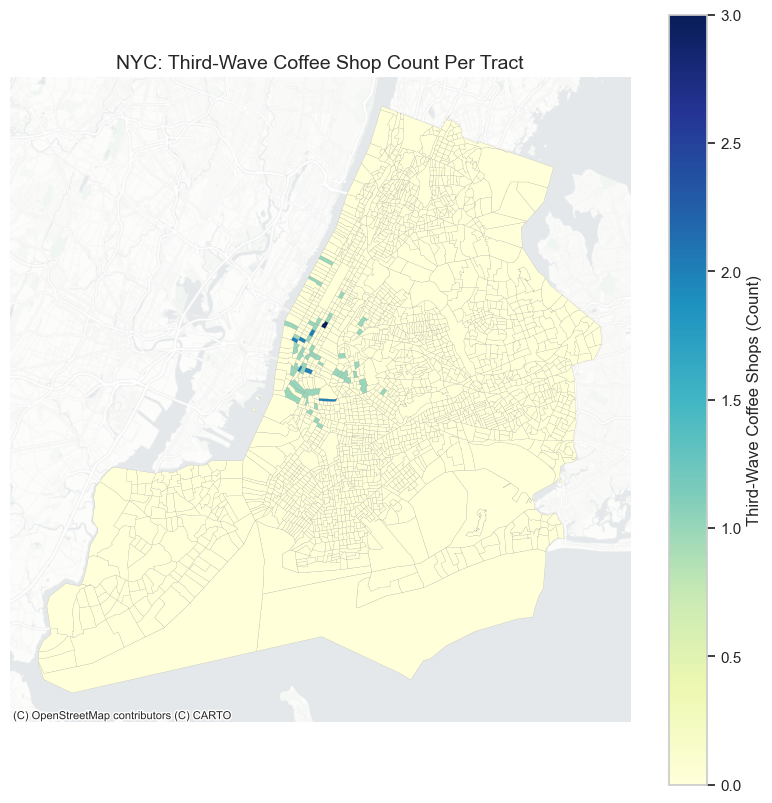

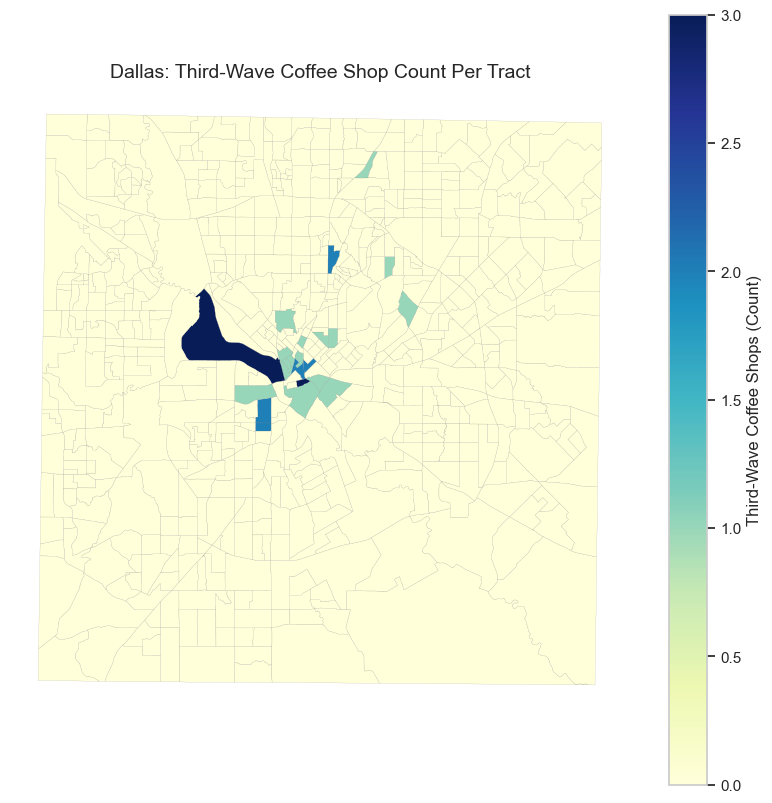

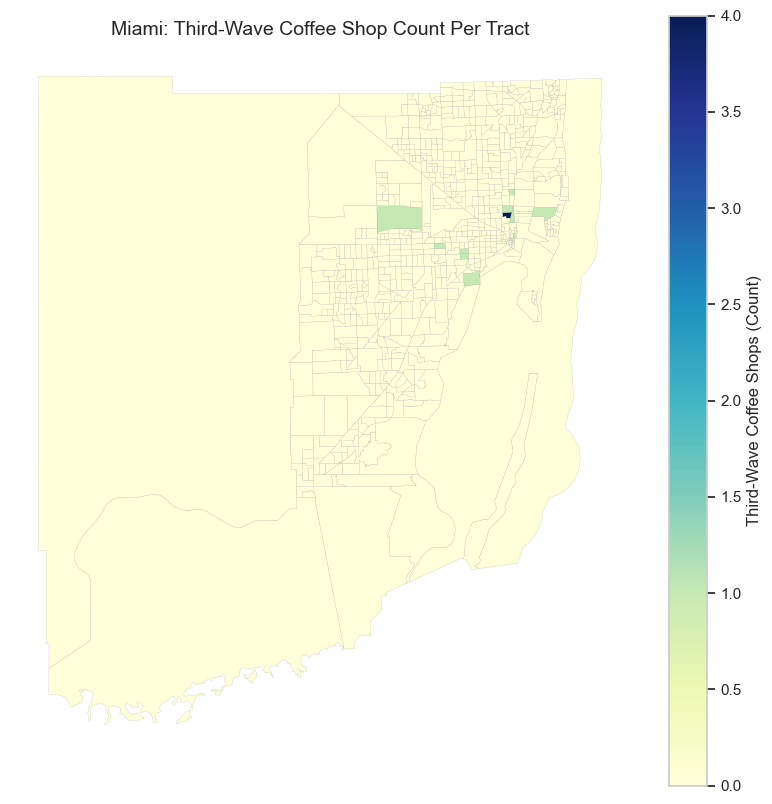

In [85]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

# === File paths ===
BASE_DIR = "/Users/chivo/Downloads/data_studio/coffee"
TRACTS = {
    "ny": f"{BASE_DIR}/tl_2022_36_tract/tl_2022_36_tract.shp",
    "tx": f"{BASE_DIR}/tl_2022_48_tract/tl_2022_48_tract.shp",
    "fl": f"{BASE_DIR}/tl_2022_12_tract/tl_2022_12_tract.shp",
}
COFFEE = f"{BASE_DIR}/coffee_with_tracts.csv"
OUTPUTS = {
    "ny": f"{BASE_DIR}/nyc_actual_count_map.svg",
    "tx": f"{BASE_DIR}/dallas_actual_count_map.svg",
    "fl": f"{BASE_DIR}/miami_actual_count_map.svg"
}
CITY_INFO = {
    "ny": {"state": "36", "countyfp": {"005", "047", "061", "081", "085"}, "title": "NYC"},
    "tx": {"state": "48", "countyfp": {"113"}, "title": "Dallas"},
    "fl": {"state": "12", "countyfp": {"086"}, "title": "Miami"},
}

# === Load coffee shop data ===
coffee_df = pd.read_csv(COFFEE)
coffee_df["GEOID"] = coffee_df["GEOID"].astype(str)

# === Function to generate map ===
def generate_actual_map(city_code):
    info = CITY_INFO[city_code]
    tract_path = TRACTS[city_code]
    out_path = OUTPUTS[city_code]
    title = f"{info['title']}: Third-Wave Coffee Shop Count Per Tract"

    # Filter and count shops
    df = coffee_df[coffee_df["GEOID"].str.startswith(info["state"])]
    counts = df.groupby("GEOID").size().reset_index(name="coffee_count")

    # Load and filter tracts
    tracts = gpd.read_file(tract_path)
    if "GEOID" not in tracts.columns:
        tracts["GEOID"] = tracts["STATEFP"] + tracts["COUNTYFP"] + tracts["TRACTCE"]
    tracts = tracts[tracts["COUNTYFP"].isin(info["countyfp"])]
    tracts = tracts.to_crs(epsg=3857)

    # Merge counts with tracts
    gdf = pd.merge(tracts, counts, on="GEOID", how="left").fillna({"coffee_count": 0})
    gdf = gpd.GeoDataFrame(gdf, geometry="geometry", crs="EPSG:3857")

    # Plot map
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(
        column="coffee_count",
        cmap="YlGnBu",
        linewidth=0.1,
        edgecolor="gray",
        legend=True,
        legend_kwds={"label": "Third-Wave Coffee Shops (Count)"},
        ax=ax,
    )

    # Add rivers (only for NYC)
    if city_code == "ny":
        cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, alpha=0.6)
    
    ax.set_title(title, fontsize=14)
    ax.axis("off")

    # Save figure
    plt.savefig(out_path, format="svg", bbox_inches="tight")
    print(f"✅ Saved actual count map to: {out_path}")

# Run for NYC, Dallas, Miami
for city in ["ny", "tx", "fl"]:
    generate_actual_map(city)


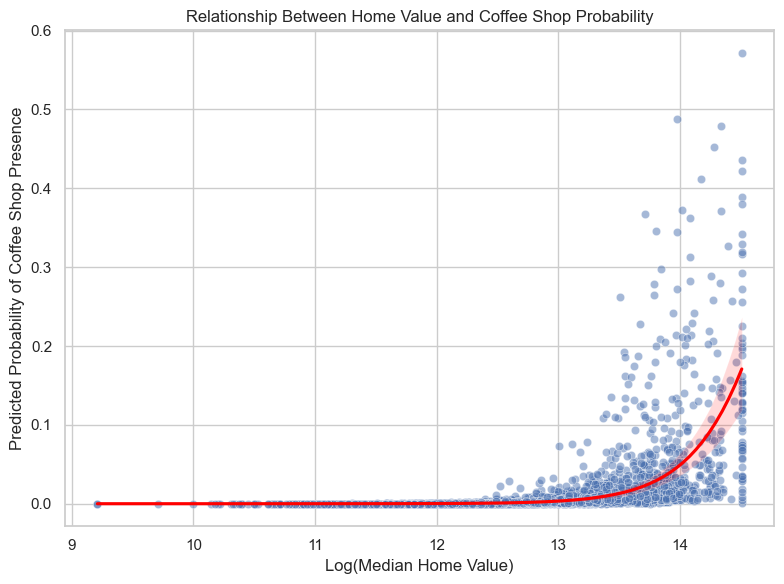

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use only rows that were used in the model
plot_df = df.loc[valid_rows].copy()

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Scatterplot
sns.scatterplot(data=plot_df, x="log_home_value", y="predicted_prob", alpha=0.5)

# Fit and plot logistic regression line
sns.regplot(
    data=plot_df,
    x="log_home_value",
    y="has_coffee",
    logistic=True,
    ci=95,
    scatter=False,
    line_kws={"color": "red"}
)

# Labels
plt.title("Relationship Between Home Value and Coffee Shop Probability")
plt.xlabel("Log(Median Home Value)")
plt.ylabel("Predicted Probability of Coffee Shop Presence")

# Save
plt.tight_layout()
plt.savefig("/Users/chivo/Downloads/data_studio/coffee/log_home_value_vs_probability.svg")
plt.show()


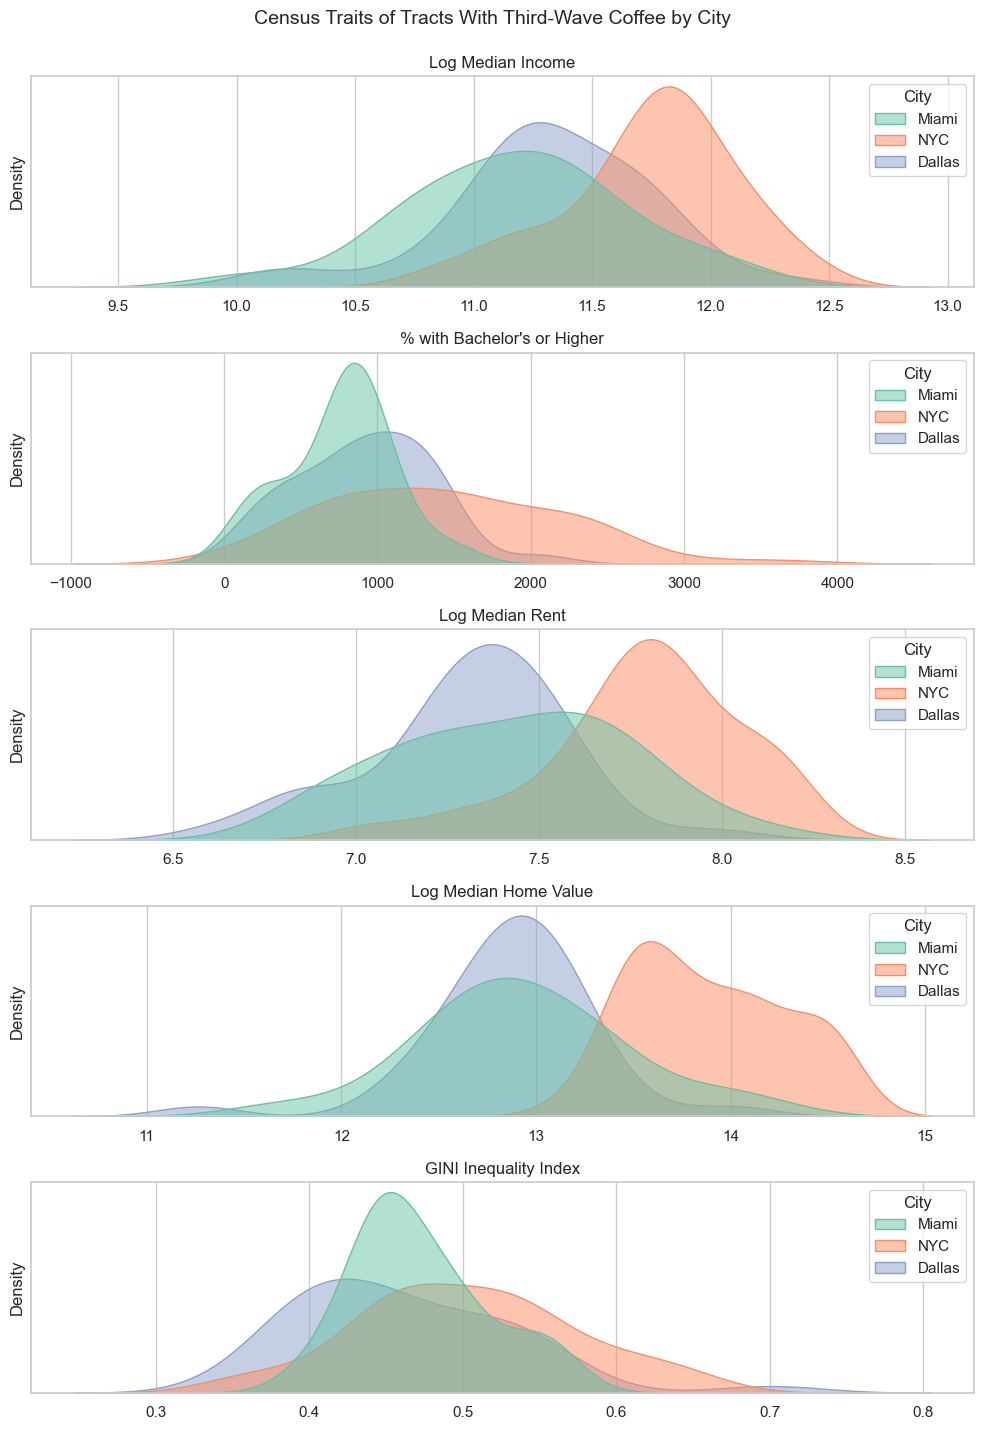

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === Load cleaned merged data ===
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/coffee_with_tracts.csv")
acs = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/acs_tracts_ny_tx_fl.csv")

# === Merge ACS data ===
df["GEOID"] = df["GEOID"].astype(str)
acs["GEOID"] = acs["GEOID"].astype(str)
merged = pd.merge(df, acs, on="GEOID", how="left")

# === Add city label ===
def label_city(geoid):
    if str(geoid).startswith("36"):
        return "NYC"
    elif str(geoid).startswith("48"):
        return "Dallas"
    elif str(geoid).startswith("12"):
        return "Miami"
    else:
        return "Other"

merged["city"] = merged["GEOID"].apply(label_city)

# === Recalculate flags and transform ===
merged["coffee_count"] = merged.groupby("GEOID")["GEOID"].transform("count")
merged["has_coffee"] = (merged["coffee_count"] >= 1).astype(int)
merged["log_income"] = pd.to_numeric(np.log1p(merged["median_income"]), errors="coerce")
merged["log_rent"] = pd.to_numeric(np.log1p(merged["median_rent"]), errors="coerce")
merged["log_home_value"] = pd.to_numeric(np.log1p(merged["median_home_value"]), errors="coerce")
merged["pct_bachelor_plus"] = pd.to_numeric(merged["pct_bachelor_plus"], errors="coerce")
merged["gini_index"] = pd.to_numeric(merged["gini_index"], errors="coerce")
merged["has_coffee"] = pd.to_numeric(merged["has_coffee"], errors="coerce")

# === Final clean filter ===
vars_to_plot = [
    ("log_income", "Log Median Income"),
    ("pct_bachelor_plus", "% with Bachelor's or Higher"),
    ("log_rent", "Log Median Rent"),
    ("log_home_value", "Log Median Home Value"),
    ("gini_index", "GINI Inequality Index")
]
filtered = merged.dropna(subset=[v[0] for v in vars_to_plot] + ["has_coffee", "city"])
filtered = filtered[filtered["city"].isin(["NYC", "Dallas", "Miami"])]

# === Plot ===
fig, axes = plt.subplots(nrows=len(vars_to_plot), ncols=1, figsize=(10, len(vars_to_plot) * 2.8), sharex=False)
for ax, (var, label) in zip(axes, vars_to_plot):
    sns.kdeplot(
        data=filtered,
        x=var,
        hue="city",
        ax=ax,
        fill=True,
        common_norm=False,
        alpha=0.5,
        palette="Set2"
    )
    ax.set_title(label)
    ax.set_ylabel("Density")
    ax.set_xlabel("")
    ax.legend_.set_title("City")
    ax.set_yticks([])

plt.tight_layout()
plt.suptitle("Census Traits of Tracts With Third-Wave Coffee by City", fontsize=14, y=1.02)
plt.savefig("/Users/chivo/Downloads/data_studio/coffee/census_traits_by_city.svg")
plt.show()


/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/647068777.py:24: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) Arial.
  plt.tight_layout()
/Users/chivo/.pyenv/versions/3.10.12/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


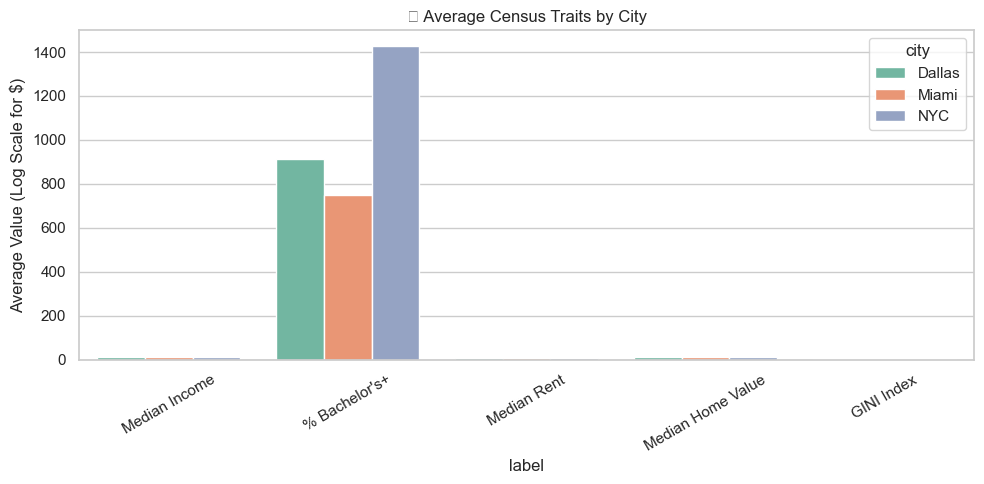

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Choose variables and titles ===
summary_vars = {
    "log_income": "Median Income",
    "pct_bachelor_plus": "% Bachelor's+",
    "log_rent": "Median Rent",
    "log_home_value": "Median Home Value",
    "gini_index": "GINI Index"
}

# === Compute averages ===
avg_df = filtered.groupby("city")[[*summary_vars.keys()]].mean().reset_index()
avg_df = avg_df.melt(id_vars="city", var_name="variable", value_name="value")
avg_df["label"] = avg_df["variable"].map(summary_vars)

# === Plot ===
plt.figure(figsize=(10, 5))
sns.barplot(data=avg_df, x="label", y="value", hue="city", palette="Set2")
plt.ylabel("Average Value (Log Scale for $)")
plt.title("💡 Average Census Traits by City")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load merged data (after assigning census + coffee per tract) ===
df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/coffee_with_tracts.csv")
acs = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/acs_tracts_ny_tx_fl.csv")

# Standardize GEOID
df["GEOID"] = df["GEOID"].astype(str)
acs["GEOID"] = acs["GEOID"].astype(str)

# === Merge ACS with shop presence ===
merged = pd.merge(acs, df[["GEOID"]], on="GEOID", how="left", indicator=True)
merged["has_coffee"] = (merged["_merge"] == "both").astype(int)

# === Add city labels ===
def assign_city(geoid):
    if geoid.startswith("36"):
        return "NYC"
    elif geoid.startswith("48"):
        return "Dallas"
    elif geoid.startswith("12"):
        return "Miami"
    else:
        return "Other"

merged["city"] = merged["GEOID"].apply(assign_city)

# === Create quintile bins for income ===
merged["income_bin"] = pd.qcut(merged["median_income"], 5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])

# === Set seaborn style ===
sns.set(style="whitegrid", palette="Set2")

# === Chart 1: Barplot of Median Income by Café Presence, Colored by City ===
plt.figure(figsize=(8, 6))
sns.barplot(
    data=merged,
    x="has_coffee", y="median_income", hue="city",
    ci=None
)
plt.title("Median Household Income by Café Presence (Colored by City)")
plt.xlabel("Has Third-Wave Café")
plt.ylabel("Median Household Income")
plt.xticks([0, 1], ["No Café", "Has Café"])
plt.tight_layout()
plt.savefig("/Users/chivo/Downloads/data_studio/coffee/chart1_income_by_coffee.svg")
plt.close()

# === Chart 2: Average Racial Composition by Café Presence, Faceted by City ===
race_cols = {
    "pct_white": "White",
    "pct_black": "Black"
}
race_df = (
    merged.groupby(["has_coffee", "city"])[list(race_cols.keys())]
    .mean().reset_index().melt(
        id_vars=["has_coffee", "city"],
        var_name="race", value_name="percentage"
    )
)
race_df["Race"] = race_df["race"].map(race_cols)

g = sns.catplot(
    data=race_df,
    kind="bar", x="Race", y="percentage",
    hue="has_coffee", col="city", ci=None,
    palette="muted", sharey=False
)
g.set_titles("{col_name}")
g.set_axis_labels("Race", "Average %")
g._legend.set_title("Has Café")
g.fig.suptitle("Racial Composition by Café Presence (Faceted by City)", y=1.03)
plt.savefig("/Users/chivo/Downloads/data_studio/coffee/chart2_race_by_city.svg")
plt.close()

# === Chart 3: Scatterplot of Education vs. Café Count, Colored by Income Quintile ===
# Load counts again
coffee_df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/coffee_with_tracts.csv")
coffee_df["GEOID"] = coffee_df["GEOID"].astype(str)
coffee_counts = coffee_df.groupby("GEOID").size().reset_index(name="coffee_count")
merged = pd.merge(merged, coffee_counts, on="GEOID", how="left").fillna({"coffee_count": 0})

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged,
    x="pct_bachelor_plus", y="coffee_count",
    hue="income_bin", style="city",
    palette="viridis", s=70
)
sns.regplot(
    data=merged,
    x="pct_bachelor_plus", y="coffee_count",
    scatter=False, color="gray", ci=None, line_kws={"linestyle": "dashed"}
)
plt.title("Higher Education and Third-Wave Café Count (by Income Quintile)")
plt.xlabel("% with Bachelor's Degree or Higher")
plt.ylabel("Number of Third-Wave Cafés")
plt.legend(title="Income Quintile / City")
plt.tight_layout()
plt.savefig("/Users/chivo/Downloads/data_studio/coffee/chart3_education_vs_cafes.svg")
plt.close()


/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2035332919.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2035332919.py:65: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


In [98]:
import os, json, cv2, torch
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from colorthief import ColorThief
from transformers import (
    Blip2Processor, Blip2ForConditionalGeneration,
    pipeline as hf_pipeline
)

# ---------- CONFIG ----------
IMG_ROOT = "/Users/chivo/Downloads/data_studio/coffee/screenshots"
OUT_CSV  = "/Users/chivo/Downloads/data_studio/coffee/website_visual_analysis.csv"
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
OBJ_SCORE = 0.20
SAVE_EVERY = 25

# ---------- MODELS ----------
blip_proc = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
blip_mod  = Blip2ForConditionalGeneration.from_pretrained(
              "Salesforce/blip2-flan-t5-xl",
              torch_dtype=torch.float16 if DEVICE=="cuda" else torch.float32
            ).to(DEVICE)

owl_pipe = hf_pipeline(
    task="zero-shot-object-detection",
    model="google/owlvit-base-patch32",
    device=0 if DEVICE=="cuda" else -1
)

# ---------- PROMPTS ----------
THEME_PROMPT = (
    "List 10–12 short visual branding themes for this cafe website screenshot. "
    "Return JSON: {\"themes\":[…],\"color_tone\":\"…\"}"
)
MEDIA_PROMPT = (
    "Does this screenshot include only static images, video thumbnails, or both? "
    "Answer JUST one word: image, video, or both."
)
OBJECT_QUERIES = [
    "coffee cup", "latte", "plant", "flower", "table", "chair",
    "barista", "logo", "menu", "sign", "window", "pattern", "dessert"
]

# ---------- HELPERS ----------
def get_dominant_color(path):
    try:
        rgb = ColorThief(path).get_color(quality=2)
        hex_ = f'#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}'
        return rgb, hex_
    except Exception:
        return (None, None)

def blip2_json_prompt(image, prompt, max_tokens=120):
    try:
        inputs = blip_proc(image, prompt, return_tensors="pt").to(DEVICE)
        out = blip_mod.generate(**inputs, max_new_tokens=max_tokens)
        txt = blip_proc.tokenizer.decode(out[0], skip_special_tokens=True)
        return txt.strip()
    except Exception as e:
        return f"[ERROR] {e}"

def detect_media_type(path):
    img = cv2.imread(path)
    if img is None: return "unknown"
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    contours,_ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        if 300 < cv2.contourArea(c) < 4000:
            approx = cv2.approxPolyDP(c, 0.15*cv2.arcLength(c,True), True)
            if len(approx) == 3:
                return "video or both"
    return "image"

# ---------- RUN ----------
rows, cache = [], 0
paths = list(Path(IMG_ROOT).rglob("*.png"))

for p in tqdm(paths, desc="Analysing website screenshots"):
    city = p.parts[-2]
    try:
        img = Image.open(p).convert("RGB")
        rgb, hexcol = get_dominant_color(str(p))

        reply = blip2_json_prompt(img, THEME_PROMPT)
        try:
            themes_json = json.loads(reply)
            theme_list  = "; ".join(themes_json.get("themes", []))
            color_tone  = themes_json.get("color_tone", "")
        except Exception:
            theme_list, color_tone = "", ""

        detections = owl_pipe(img, candidate_labels=OBJECT_QUERIES)
        obj_list = [d["label"] for d in detections if d["score"] >= OBJ_SCORE]
        obj_str  = "; ".join(sorted(set(obj_list)))

        media_reply = blip2_json_prompt(img, MEDIA_PROMPT, max_tokens=5)
        if "image" not in media_reply and "video" not in media_reply:
            media_reply = detect_media_type(str(p))

        rows.append({
            "image_path": str(p),
            "city": city,
            "dominant_rgb": rgb,
            "dominant_hex": hexcol,
            "color_tone": color_tone,
            "visual_themes": theme_list,
            "objects": obj_str,
            "media_type": media_reply
        })

    except Exception as e:
        rows.append({
            "image_path": str(p), "city": city,
            "dominant_rgb": "", "dominant_hex": "",
            "color_tone": "", "visual_themes": "[ERROR]",
            "objects": "", "media_type": "", "error": str(e)
        })

    cache += 1
    if cache == SAVE_EVERY:
        pd.DataFrame(rows).to_csv(OUT_CSV, index=False)
        print(f"💾 Interim save ({len(rows)} rows)")
        cache = 0

pd.DataFrame(rows).to_csv(OUT_CSV, index=False)
print(f"✅ Done. Saved → {OUT_CSV}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu
Analysing website screenshots:   5%|▍         | 25/538 [03:48<1:17:48,  9.10s/it]

💾 Interim save (25 rows)


Analysing website screenshots:   9%|▉         | 50/538 [07:38<1:16:17,  9.38s/it]

💾 Interim save (50 rows)


Analysing website screenshots:  14%|█▍        | 75/538 [22:20<3:12:16, 24.92s/it]  

💾 Interim save (75 rows)


Analysing website screenshots:  19%|█▊        | 100/538 [25:59<1:03:05,  8.64s/it]

💾 Interim save (100 rows)


Analysing website screenshots:  23%|██▎       | 125/538 [29:46<1:04:46,  9.41s/it]

💾 Interim save (125 rows)


Analysing website screenshots:  28%|██▊       | 150/538 [1:06:40<4:03:17, 37.62s/it]  

💾 Interim save (150 rows)


Analysing website screenshots:  33%|███▎      | 175/538 [1:30:48<3:05:44, 30.70s/it]  

💾 Interim save (175 rows)


Analysing website screenshots:  37%|███▋      | 200/538 [1:53:54<4:15:56, 45.43s/it]  

💾 Interim save (200 rows)


Analysing website screenshots:  42%|████▏     | 225/538 [2:27:35<1:29:48, 17.22s/it]  

💾 Interim save (225 rows)


Analysing website screenshots:  46%|████▋     | 250/538 [3:01:24<3:15:53, 40.81s/it]  

💾 Interim save (250 rows)


Analysing website screenshots:  51%|█████     | 275/538 [3:27:42<7:38:43, 104.65s/it] 

💾 Interim save (275 rows)


Analysing website screenshots:  56%|█████▌    | 300/538 [3:46:32<49:56, 12.59s/it]    

💾 Interim save (300 rows)


Analysing website screenshots:  60%|██████    | 325/538 [4:22:57<2:00:25, 33.92s/it]  

💾 Interim save (325 rows)


Analysing website screenshots:  65%|██████▌   | 350/538 [5:01:19<7:44:17, 148.18s/it] 

💾 Interim save (350 rows)


Analysing website screenshots:  70%|██████▉   | 375/538 [5:21:24<33:39, 12.39s/it]    

💾 Interim save (375 rows)


Analysing website screenshots:  74%|███████▍  | 400/538 [5:26:36<21:58,  9.56s/it]  

💾 Interim save (400 rows)


Analysing website screenshots:  79%|███████▉  | 425/538 [5:30:27<17:16,  9.17s/it]

💾 Interim save (425 rows)


Analysing website screenshots:  84%|████████▎ | 450/538 [5:34:22<13:14,  9.03s/it]

💾 Interim save (450 rows)


Analysing website screenshots:  88%|████████▊ | 475/538 [5:38:16<09:40,  9.21s/it]

💾 Interim save (475 rows)


Analysing website screenshots:  93%|█████████▎| 500/538 [5:42:03<05:41,  8.99s/it]

💾 Interim save (500 rows)


Analysing website screenshots:  98%|█████████▊| 525/538 [5:45:52<02:00,  9.25s/it]

💾 Interim save (525 rows)


Analysing website screenshots: 100%|██████████| 538/538 [5:47:56<00:00, 38.80s/it]

✅ Done. Saved → /Users/chivo/Downloads/data_studio/coffee/website_visual_analysis.csv


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from pathlib import Path

# === Config ===
INPUT_CSV = "/Users/chivo/Downloads/data_studio/coffee/website_visual_analysis.csv"
OUT_ALL_LABELED = "/Users/chivo/Downloads/data_studio/coffee/all_color_labeled_squares.svg"
OUT_CITY_LABELED = "/Users/chivo/Downloads/data_studio/coffee/city_color_labeled_squares.svg"

SQUARE_SIZE = 20
SQUARE_SPACING = 10
FONT_SIZE = 6
GRID_COLUMNS = 10

# === Load Data ===
df = pd.read_csv(INPUT_CSV)
df = df.dropna(subset=["dominant_hex", "city", "image_path"])
df["dominant_hex"] = df["dominant_hex"].astype(str).str.strip()
df["city"] = df["city"].astype(str).str.strip()

# Extract shop name from image path
def extract_shop_name(path):
    parts = Path(path).parts
    if len(parts) >= 2:
        return parts[-2] + "/" + Path(path).stem.replace("_", " ")
    return Path(path).stem.replace("_", " ")

df["shop_label"] = df["image_path"].apply(extract_shop_name)

# === 1. Plot all colors with labels ===
def plot_all_labeled(df, output_path):
    total = len(df)
    rows = math.ceil(total / GRID_COLUMNS)
    fig, ax = plt.subplots(figsize=(GRID_COLUMNS * 1.6, rows * 1.2))

    for idx, row in df.iterrows():
        r = idx // GRID_COLUMNS
        c = idx % GRID_COLUMNS
        x = c * (SQUARE_SIZE + SQUARE_SPACING)
        y = -r * (SQUARE_SIZE + SQUARE_SPACING)

        ax.add_patch(patches.Rectangle(
            (x, y), SQUARE_SIZE, SQUARE_SIZE,
            facecolor=row["dominant_hex"],
            edgecolor="black"
        ))
        ax.text(x + SQUARE_SIZE + 2, y + SQUARE_SIZE * 0.75,
                row["shop_label"], fontsize=FONT_SIZE, va="top")
        ax.text(x + SQUARE_SIZE + 2, y + SQUARE_SIZE * 0.25,
                row["dominant_hex"], fontsize=FONT_SIZE, va="top", color="gray")

    ax.set_xlim(0, (SQUARE_SIZE + SQUARE_SPACING) * GRID_COLUMNS + 100)
    ax.set_ylim(-(SQUARE_SIZE + SQUARE_SPACING) * rows, 10)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(output_path, format="svg", bbox_inches="tight")
    plt.close()
    print(f"✅ Saved: {output_path}")

# === 2. Plot grouped by city with labels ===
def plot_city_labeled(df, output_path):
    grouped = df.groupby("city")
    cities = list(grouped.groups.keys())
    max_per_city = grouped.size().max()

    fig_width = GRID_COLUMNS * 1.8
    fig_height = len(cities) * 1.8
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    row_idx = 0
    for city in cities:
        group = grouped.get_group(city).reset_index(drop=True)
        for i, row in group.iterrows():
            c = i % GRID_COLUMNS
            r = row_idx + (i // GRID_COLUMNS)
            x = c * (SQUARE_SIZE + SQUARE_SPACING)
            y = -r * (SQUARE_SIZE + SQUARE_SPACING)

            ax.add_patch(patches.Rectangle(
                (x, y), SQUARE_SIZE, SQUARE_SIZE,
                facecolor=row["dominant_hex"],
                edgecolor="black"
            ))
            ax.text(x + SQUARE_SIZE + 2, y + SQUARE_SIZE * 0.75,
                    row["shop_label"], fontsize=FONT_SIZE, va="top")
            ax.text(x + SQUARE_SIZE + 2, y + SQUARE_SIZE * 0.25,
                    row["dominant_hex"], fontsize=FONT_SIZE, va="top", color="gray")

        # City label
        ax.text(-10, -row_idx * (SQUARE_SIZE + SQUARE_SPACING) - 5,
                city, fontsize=FONT_SIZE + 2, ha="right", va="bottom", weight="bold")
        row_idx += math.ceil(len(group) / GRID_COLUMNS) + 1

    ax.set_xlim(-60, (SQUARE_SIZE + SQUARE_SPACING) * GRID_COLUMNS + 120)
    ax.set_ylim(-row_idx * (SQUARE_SIZE + SQUARE_SPACING), 10)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(output_path, format="svg", bbox_inches="tight")
    plt.close()
    print(f"✅ Saved: {output_path}")

# === Run Both ===
plot_all_labeled(df, OUT_ALL_LABELED)
plot_city_labeled(df, OUT_CITY_LABELED)


/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:57: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:57: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:57: UserWarning: Glyph 24215 (\N{CJK UNIFIED IDEOGRAPH-5E97}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:57: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:57: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2

✅ Saved: /Users/chivo/Downloads/data_studio/coffee/all_color_labeled_squares.svg


/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:99: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:99: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:99: UserWarning: Glyph 12512 (\N{KATAKANA LETTER MU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:99: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:99: UserWarning: Glyph 12527 (\N{KATAKANA LETTER WA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_18000/2478193148.py:99: UserWar

✅ Saved: /Users/chivo/Downloads/data_studio/coffee/city_color_labeled_squares.svg


✅ Saved to /Users/chivo/Downloads/data_studio/coffee/city_color_profiles.svg


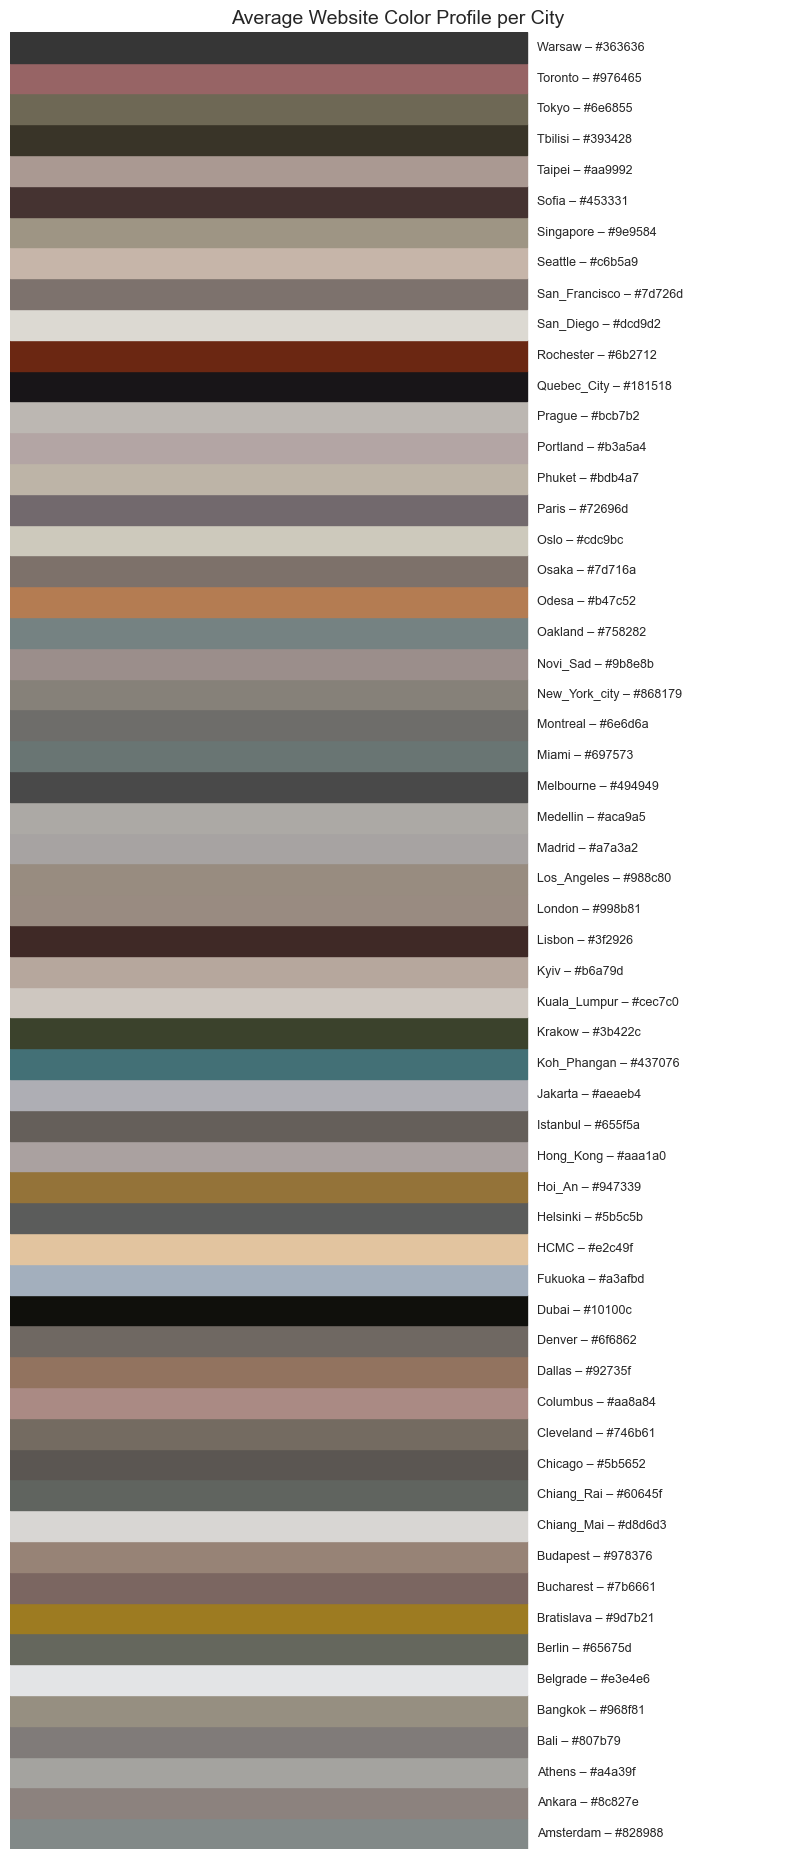

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgb
import numpy as np
import os

# === Load data ===
file_path = "/Users/chivo/Downloads/data_studio/coffee/website_visual_analysis.csv"
df = pd.read_csv(file_path)

# === Clean and extract ===
df['dominant_hex'] = df['dominant_hex'].fillna("").astype(str).str.strip()
df = df[df['dominant_hex'].str.startswith('#')]
df['rgb'] = df['dominant_hex'].apply(lambda x: to_rgb(x))

# === Extract city from path ===
df['city'] = df['image_path'].str.extract(r'/screenshots/([^/]+)/')

# === Compute average RGB per city ===
city_colors = df.groupby('city')['rgb'].apply(lambda x: tuple(np.mean(x.tolist(), axis=0))).reset_index()

# === Plot ===
fig, ax = plt.subplots(figsize=(10, len(city_colors) * 0.4))
for i, row in city_colors.iterrows():
    rgb = row['rgb']
    hex_color = '#%02x%02x%02x' % tuple(int(255 * c) for c in rgb)
    ax.add_patch(Rectangle((0, i), 10, 1, color=hex_color))
    ax.text(10.2, i + 0.5, f"{row['city']} – {hex_color}", va='center', ha='left', fontsize=9)

ax.set_xlim(0, 15)
ax.set_ylim(0, len(city_colors))
ax.axis('off')
plt.title("Average Website Color Profile per City", fontsize=14)

# === Save ===
output_svg = "/Users/chivo/Downloads/data_studio/coffee/city_color_profiles.svg"
plt.savefig(output_svg, format="svg", bbox_inches="tight")
print(f"✅ Saved to {output_svg}")


In [102]:
# !pip install pandas matplotlib seaborn scipy


Annotated + Clustered Word Matrix

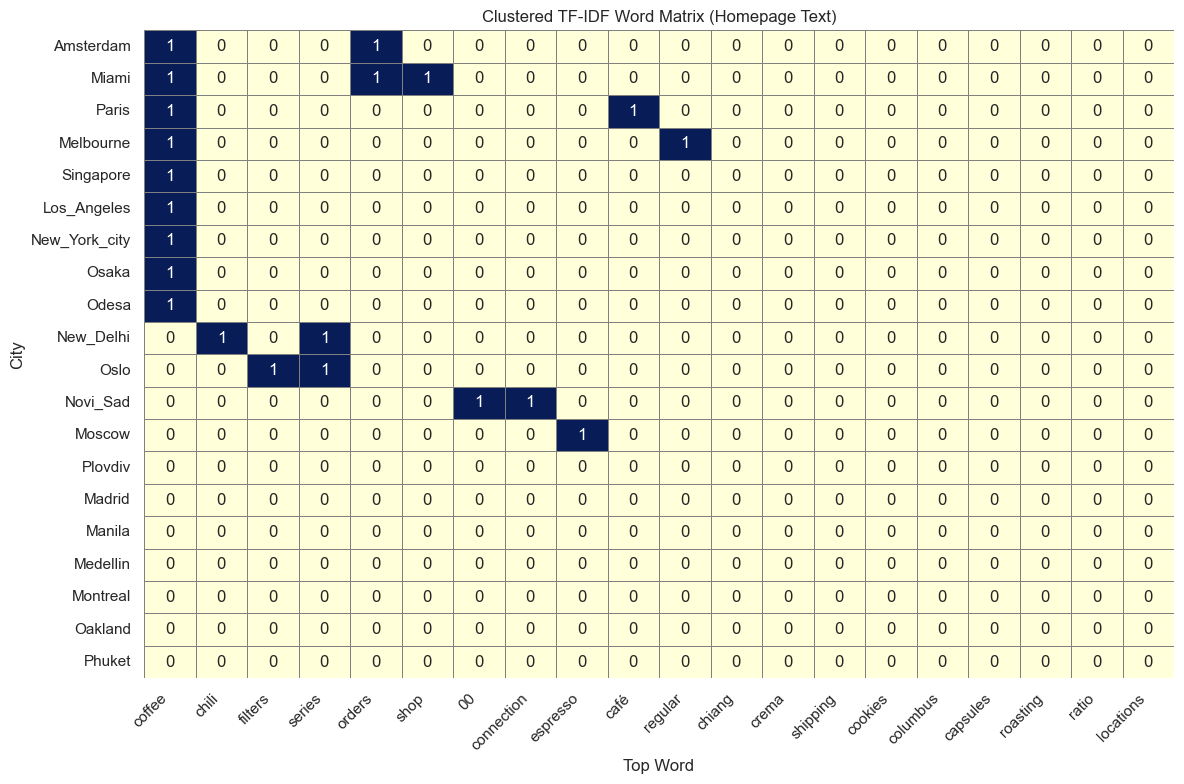

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

# === Load your data ===
file_path = "/Users/chivo/Downloads/data_studio/coffee/tfidf_homepage_top_words_by_city.csv"
df = pd.read_csv(file_path)

# === Reshape to long format ===
df_long = df.melt(
    id_vars=["Unnamed: 0"],
    value_vars=["top_word_1", "top_word_2", "top_word_3", "top_word_4", "top_word_5"],
    var_name="rank",
    value_name="word"
)
df_long = df_long.rename(columns={"Unnamed: 0": "city"})

# === Create binary matrix of city x word ===
df_long["value"] = 1
matrix = df_long.pivot_table(index="city", columns="word", values="value", fill_value=0)

# === Limit size for readability ===
top_cities = matrix.sum(axis=1).sort_values(ascending=False).head(20).index
top_words = matrix.sum(axis=0).sort_values(ascending=False).head(20).index
filtered_matrix = matrix.loc[top_cities, top_words]

# === Cluster rows (cities) and columns (words) ===
row_linkage = linkage(pdist(filtered_matrix, metric='euclidean'), method='ward')
col_linkage = linkage(pdist(filtered_matrix.T, metric='euclidean'), method='ward')

# Reorder matrix
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)
clustered_matrix = filtered_matrix.iloc[row_order, col_order]

# === Plot clustered heatmap ===
plt.figure(figsize=(12, 8))
sns.heatmap(
    clustered_matrix,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    annot=True,
    fmt=".0f",  # <-- FIXED HERE to handle float formatting
    cbar=False
)

plt.title("Clustered TF-IDF Word Matrix (Homepage Text)")
plt.xlabel("Top Word")
plt.ylabel("City")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# === Save plot if needed ===
# plt.savefig("clustered_word_matrix.png", dpi=300)

plt.show()


In [93]:
import pandas as pd

meta_df = pd.read_csv("/Users/chivo/Downloads/data_studio/coffee/IG_OCR_with_Matched_City_(final).csv")
print(meta_df.columns.tolist())


['filename', 'ocr_text', 'char_count', 'themes', 'city', 'matched_ city']


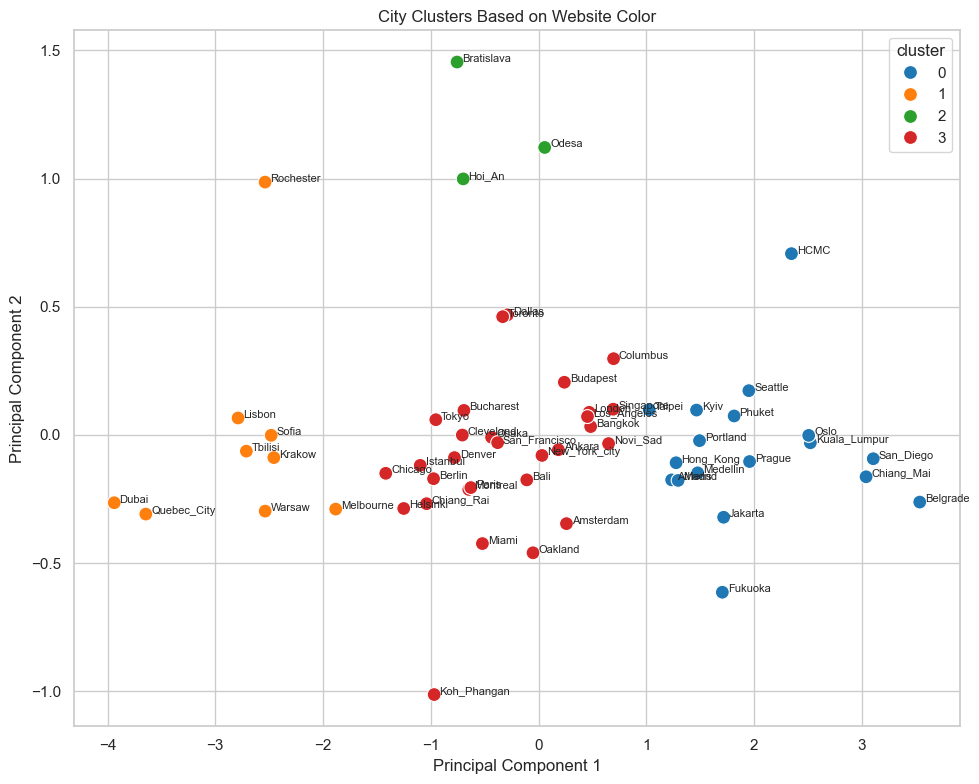

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import ast

# === Load your CSV ===
file_path = "/Users/chivo/Downloads/data_studio/coffee/website_visual_analysis.csv"
df = pd.read_csv(file_path)

# === Clean RGB and city ===
df = df[['city', 'dominant_rgb']]
df = df.dropna()
df['dominant_rgb'] = df['dominant_rgb'].apply(ast.literal_eval)  # parse RGB string to tuple
rgb_df = pd.DataFrame(df['dominant_rgb'].tolist(), columns=['R', 'G', 'B'])
rgb_df['city'] = df['city']

# === Average color per city ===
city_rgb = rgb_df.groupby('city')[['R', 'G', 'B']].mean().reset_index()

# === Scale RGB for clustering ===
scaler = StandardScaler()
scaled_rgb = scaler.fit_transform(city_rgb[['R', 'G', 'B']])

# === KMeans clustering ===
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
city_rgb['cluster'] = kmeans.fit_predict(scaled_rgb)

# === PCA for 2D visualization ===
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_rgb)
city_rgb['PC1'] = pca_result[:, 0]
city_rgb['PC2'] = pca_result[:, 1]

# === Plot ===
plt.figure(figsize=(10, 8))
sns.scatterplot(data=city_rgb, x='PC1', y='PC2', hue='cluster', palette='tab10', s=100)
for _, row in city_rgb.iterrows():
    plt.text(row['PC1'] + 0.05, row['PC2'], row['city'], fontsize=8)
plt.title("City Clusters Based on Website Color")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


In [128]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib

# === CONFIG ===
CAFE_CSV = "ig_merged_with_location.csv"
LANDMARK_CSV = "landmarks_filled.csv"
GEOJSON_DIR = "geojson"
OUTPUT_DIR = "output_svgs"

# === Init output folder
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Font fix for special characters
matplotlib.rcParams["font.family"] = "DejaVu Sans"

# === Load Café Data
df = pd.read_csv(CAFE_CSV)
df = df.dropna(subset=["latitude", "longitude", "themes", "matched_ city"])
df["city"] = (
    df["matched_ city"]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace("-", " ")
    .str.replace("_", " ")
)
df["city"] = df["city"].replace({
    "hcmc": "ho chi minh city",
    "lake city": "salt lake city"
})
df["primary_theme"] = df["themes"].str.split(",").str[0].str.strip()

cafes_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# === Load Landmarks
landmarks = pd.read_csv(LANDMARK_CSV)
landmarks["city"] = landmarks["city"].astype(str).str.strip().str.lower()
landmarks_gdf = gpd.GeoDataFrame(
    landmarks,
    geometry=gpd.points_from_xy(landmarks["longitude"], landmarks["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# === Color Palette
pastel_palette = sns.color_palette("Set2", 12) + sns.color_palette("Pastel1", 9)
unique_themes = sorted(cafes_gdf["primary_theme"].dropna().unique())
palette_cycle = (pastel_palette * ((len(unique_themes) // len(pastel_palette)) + 1))[:len(unique_themes)]
theme_colors = dict(zip(unique_themes, palette_cycle))

# === Aliases
CITY_ALIASES = {
    "warszawa": "warsaw", "seatle": "seattle", "toronto_crs84": "toronto",
    "osaka.min": "osaka", "fukuoka.min": "fukuoka", "new-york-city-boroughs": "new york",
    "los-angeles-county": "los angeles", "bangkok-districts": "bangkok",
    "sanfrancisco": "san francisco", "hong_kong": "hong kong", "grad beograd": "belgrade",
    "salt-lake-city": "salt lake city", "ho-chi-minh-city": "ho chi minh city"
}

# === Loop
for file in os.listdir(GEOJSON_DIR):
    if not file.endswith(".geojson") and not file.endswith(".json"):
        continue

    base = file.replace(".geojson", "").replace(".json", "").replace("_", " ").replace("-", " ").strip().lower()
    city_key = CITY_ALIASES.get(base, base)
    cafes_city = cafes_gdf[cafes_gdf["city"] == city_key]

    if cafes_city.empty:
        print(f"⚠️ No cafés found for {city_key}")
        continue

    try:
        boundary = gpd.read_file(os.path.join(GEOJSON_DIR, file))
        if boundary.crs is None:
            boundary.crs = "EPSG:4326"
        boundary = boundary.to_crs(epsg=3857)
    except Exception as e:
        print(f"❌ Skipping {file} – {e}")
        continue

    landmarks_city = landmarks_gdf[landmarks_gdf["city"] == city_key]
    city_name = city_key.title()
    fig_size = min(14, max(8, len(cafes_city) // 20))

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    boundary.plot(ax=ax, color="#f7f7f7", edgecolor="#cccccc", linewidth=0.5, alpha=0.4)

    for theme, group in cafes_city.groupby("primary_theme"):
        color = theme_colors.get(theme, "gray")
        group.plot(ax=ax, color=color, markersize=50, edgecolor="white", linewidth=0.6, alpha=0.95, label=theme)

    if not landmarks_city.empty:
        landmarks_city.plot(ax=ax, color="black", marker="o", markersize=20, zorder=5)
        for _, row in landmarks_city.iterrows():
            ax.annotate(row["landmark"], xy=(row.geometry.x, row.geometry.y),
                        xytext=(3, 3), textcoords="offset points",
                        fontsize=8, color="black")

    buffer = 2500
    x_min, x_max = cafes_city.geometry.x.min(), cafes_city.geometry.x.max()
    y_min, y_max = cafes_city.geometry.y.min(), cafes_city.geometry.y.max()
    ax.set_xlim(x_min - buffer, x_max + buffer)
    ax.set_ylim(y_min - buffer, y_max + buffer)

    plt.title(f"{city_name} – Instagram Cafés by Theme", fontsize=14)
    ax.legend(title="Primary Theme", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)

    plt.axis("off")
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])

    output_path = os.path.join(OUTPUT_DIR, f"map_{city_key.replace(' ', '_')}.svg")
    plt.savefig(output_path, format="svg")
    plt.close()
    print(f"✅ Saved {output_path}")


✅ Saved output_svgs/map_belgrade.svg
✅ Saved output_svgs/map_chiang_mai.svg
✅ Saved output_svgs/map_dallas.svg
✅ Saved output_svgs/map_phuket.svg
✅ Saved output_svgs/map_prague.svg
✅ Saved output_svgs/map_belgrade.svg
✅ Saved output_svgs/map_san_francisco.svg
✅ Saved output_svgs/map_dubai.svg
✅ Saved output_svgs/map_singapore.svg
✅ Saved output_svgs/map_san_diego.svg
✅ Saved output_svgs/map_berlin.svg
✅ Saved output_svgs/map_london.svg
✅ Saved output_svgs/map_toronto.svg
✅ Saved output_svgs/map_istanbul.svg
✅ Saved output_svgs/map_bangkok.svg
✅ Saved output_svgs/map_ho_chi_minh_city.svg
✅ Saved output_svgs/map_barcelona.svg
✅ Saved output_svgs/map_bali.svg
✅ Saved output_svgs/map_chicago.svg
✅ Saved output_svgs/map_paris.svg
✅ Saved output_svgs/map_kyiv.svg
✅ Saved output_svgs/map_chiang_rai.svg
✅ Saved output_svgs/map_moscow.svg
✅ Saved output_svgs/map_copenhagen.svg
✅ Saved output_svgs/map_salt_lake_city.svg
✅ Saved output_svgs/map_budapest.svg
✅ Saved output_svgs/map_portland.svg
✅ 

In [126]:
print(sorted(df["city"].unique()))


['amsterdam', 'ankara', 'asheville', 'athens', 'bali', 'bangalore', 'bangkok', 'bar athens', 'barcelona', 'belgrade', 'berlin', 'bratislava', 'brewers athens', 'brunch athens', 'bucharest', 'budapest', 'cambodia', 'chiang mai', 'chiang rai', 'chicago', 'cleveland', 'co athens', 'coffee athens', 'coffeeology athens', 'cologne', 'columbus', 'copenhagen', 'cup athens', 'da nang', 'dallas', 'denver', 'detroit', 'dive athens', 'dubai', 'fukuoka', 'hannover', 'hanoi', 'hcmc', 'helsinki', 'hoi an', 'hong kong', 'house athens', 'istanbul', 'jakarta', 'jerusalem', 'kaohsiung', 'khon kaen', 'kigali', 'koh phangan', 'koh samui', 'krakow', 'kuala lumpur', 'kyiv', 'kyoto', 'lab athens', 'lake city', 'leipzig', 'lisbon', 'ljubljana', 'london', 'los angeles', 'lviv', 'made athens', 'madrid', 'malaga', 'manila', 'marrakesh', 'medellin', 'melbourne', 'miami', 'montpellier', 'montreal', 'moscow', 'negri athens', 'new delhi', 'new york', 'nicosia', 'nomad athens', 'novi sad', 'oakland', 'odesa', 'osaka',

In [120]:
from pathlib import Path
import geopandas as gpd

geojson_dir = Path("/Users/chivo/Downloads/data_studio/coffee/geojson")
for f in geojson_dir.glob("*.geojson"):
    try:
        gdf = gpd.read_file(f)
        print(f"✅ Valid: {f.name}")
    except Exception as e:
        print(f"❌ Invalid: {f.name} – {e}")


✅ Valid: toronto_crs84.geojson
✅ Valid: Chiang Mai.geojson
✅ Valid: dallas.geojson
✅ Valid: Phuket.geojson
✅ Valid: prague.geojson
✅ Valid: Grad Beograd.geojson
✅ Valid: dubai.geojson
✅ Valid: seatle.geojson
✅ Valid: san-diego.geojson
✅ Valid: Berlin.geojson
✅ Valid: london.geojson
✅ Valid: Istanbul.geojson
✅ Valid: los-angeles-county.geojson
✅ Valid: ho-chi-minh-city.geojson
✅ Valid: bali.geojson
✅ Valid: chicago.geojson
✅ Valid: paris.geojson
✅ Valid: kyiv.geojson
✅ Valid: Chiang Rai.geojson
✅ Valid: moscow.geojson
✅ Valid: copenhagen.geojson
✅ Valid: fukuoka.min.geojson
✅ Valid: salt-lake-city.geojson
✅ Valid: budapest.geojson
✅ Valid: portland.geojson
✅ Valid: warszawa.geojson
✅ Valid: new-york-city-boroughs.geojson
✅ Valid: osaka.min.geojson
✅ Valid: barris.geojson
✅ Valid: melbourne.geojson
✅ Valid: tokyo.geojson
✅ Valid: denver.geojson
✅ Valid: Bangkok-districts.geojson
✅ Valid: Montreal.geojson
✅ Valid: Kuala_Lumpur.geojson
❌ Invalid: cleveland.geojson – Failed to read GeoJSON 

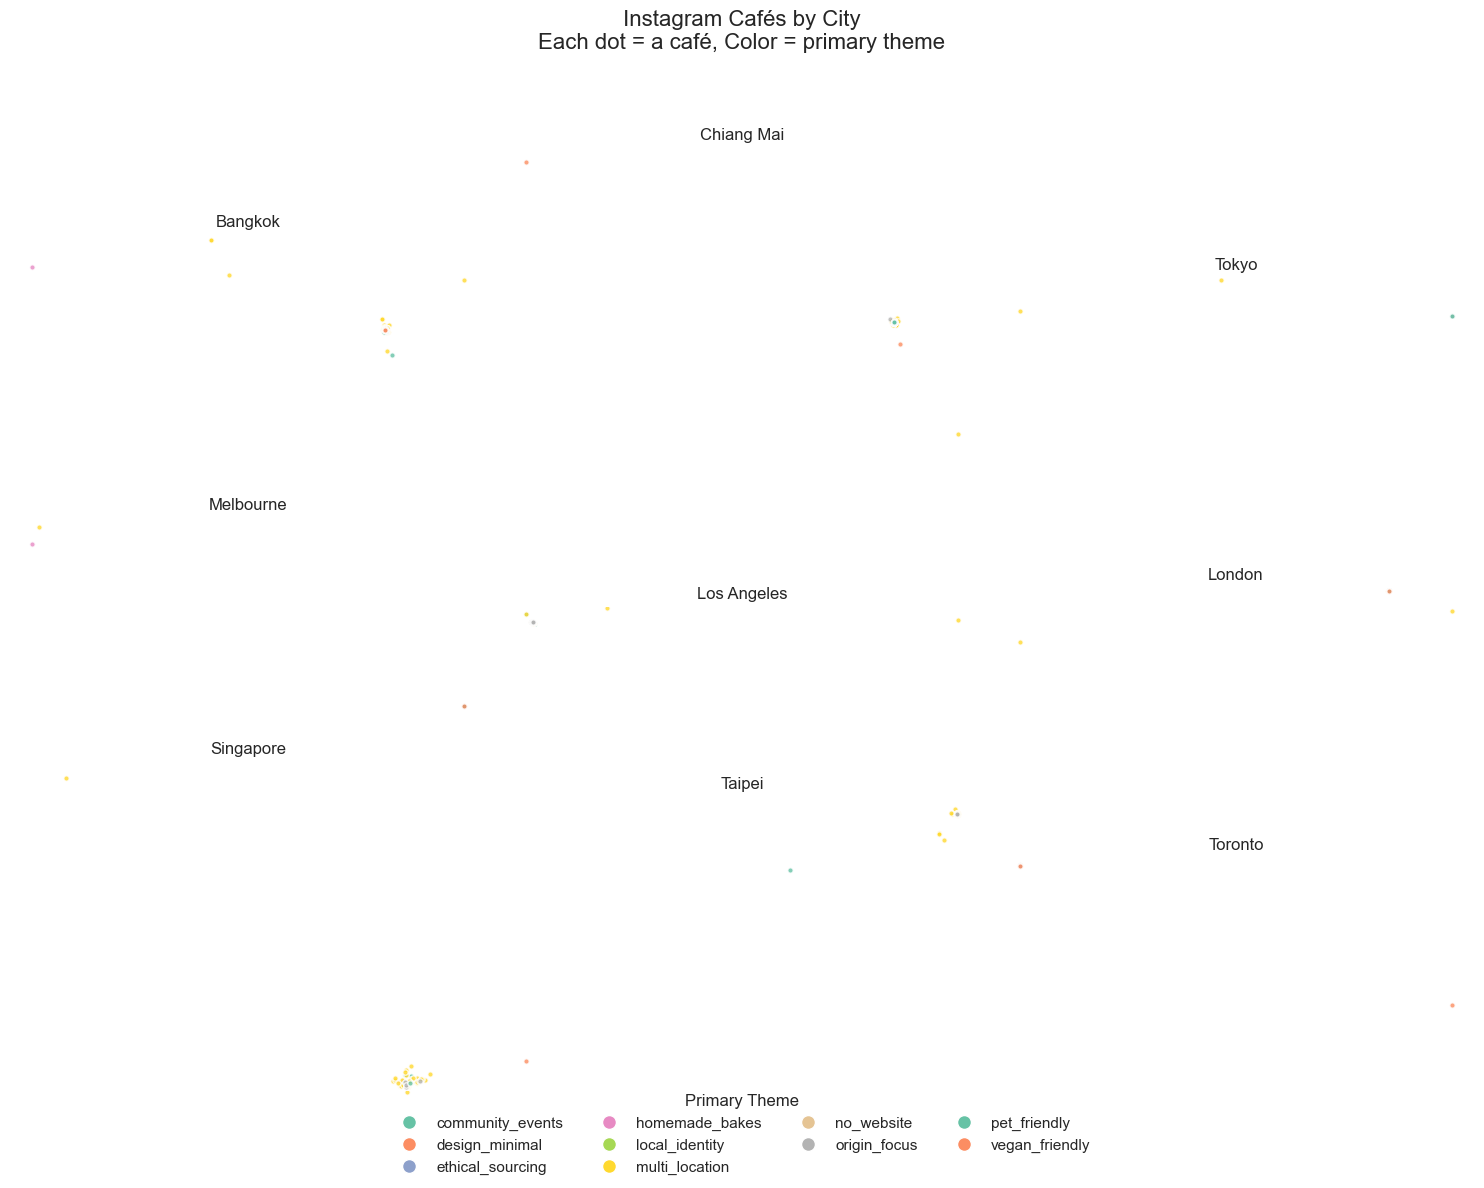

In [110]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

# === Load data ===
csv_path = "/Users/chivo/Downloads/data_studio/coffee/ig_merged_with_location.csv"
df = pd.read_csv(csv_path)

# === Preprocess ===
df = df.dropna(subset=["latitude", "longitude", "themes", "matched_ city"])
df["city"] = df["matched_ city"].str.replace(" ", "_")
df["primary_theme"] = df["themes"].str.split(",").str[0].str.strip()

# Top cities
top_cities = df["city"].value_counts().head(9).index
df = df[df["city"].isin(top_cities)]

# Color palette
unique_themes = sorted(df["primary_theme"].dropna().unique())
palette = sns.color_palette("Set2", len(unique_themes))
theme_color_map = dict(zip(unique_themes, palette))

# GeoDataFrame with Web Mercator projection
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["longitude"], df["latitude"]), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

# === Facet-wrapped map ===
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, city in enumerate(top_cities):
    ax = axes[i]
    subset = gdf[gdf["city"] == city]
    
    # Plot dots colored by theme
    for theme, group in subset.groupby("primary_theme"):
        color = theme_color_map.get(theme, "gray")
        group.plot(ax=ax, markersize=15, color=color, edgecolor="white", alpha=0.8)

    # Optional: add basemap
    try:
        import contextily as cx
        cx.add_basemap(ax, crs=subset.crs, source=cx.providers.Stamen.TonerLite)
    except:
        pass

    ax.set_title(city.replace("_", " "), fontsize=12)
    ax.set_axis_off()

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Shared legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=theme,
                      markerfacecolor=color, markersize=10)
           for theme, color in theme_color_map.items()]
fig.legend(handles=handles, title="Primary Theme", loc="lower center", ncol=4, frameon=False)

plt.suptitle("Instagram Cafés by City\nEach dot = a café, Color = primary theme", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


In [133]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === CONFIG ===
CAFE_CSV = "ig_merged_with_location.csv"
LANDMARK_CSV = "landmarks_filled.csv"
GEOJSON_FILE = "geojson/Warsaw.geojson"  # or change to correct path if needed
OUTPUT_SVG = "map_warsaw_large.svg"

# === Load Café Data
df = pd.read_csv(CAFE_CSV)
df = df.dropna(subset=["latitude", "longitude", "themes", "matched_ city"])
df["city"] = (
    df["matched_ city"]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace("-", " ")
    .str.replace("_", " ")
)
df["city"] = df["city"].replace({
    "hcmc": "ho chi minh city",
    "lake city": "salt lake city",
    "warszawa": "warsaw"
})
df["primary_theme"] = df["themes"].str.split(",").str[0].str.strip()

cafes_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

cafes_city = cafes_gdf[cafes_gdf["city"] == "warsaw"]
if cafes_city.empty:
    print("⚠️ No cafés found for Warsaw")
    exit()

# === Load Landmarks
landmarks = pd.read_csv(LANDMARK_CSV)
landmarks["city"] = landmarks["city"].astype(str).str.strip().str.lower()
landmarks_gdf = gpd.GeoDataFrame(
    landmarks,
    geometry=gpd.points_from_xy(landmarks["longitude"], landmarks["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)
landmarks_city = landmarks_gdf[landmarks_gdf["city"] == "warsaw"]

# === Load GeoJSON for Warsaw
boundary = gpd.read_file(GEOJSON_FILE)
if boundary.crs is None:
    boundary.crs = "EPSG:4326"
boundary = boundary.to_crs(epsg=3857)

# === Palette
pastel_palette = sns.color_palette("Set2", 12) + sns.color_palette("Pastel1", 9)
unique_themes = sorted(cafes_gdf["primary_theme"].dropna().unique())
palette_cycle = (pastel_palette * ((len(unique_themes) // len(pastel_palette)) + 1))[:len(unique_themes)]
theme_colors = dict(zip(unique_themes, palette_cycle))

# === Plot
fig, ax = plt.subplots(figsize=(12, 12))
boundary.plot(ax=ax, color="#f7f7f7", edgecolor="#cccccc", linewidth=0.5, alpha=0.4)

for theme, group in cafes_city.groupby("primary_theme"):
    color = theme_colors.get(theme, "gray")
    group.plot(ax=ax, color=color, markersize=5, edgecolor="white", linewidth=0.4, alpha=0.95, label=theme)

if not landmarks_city.empty:
    landmarks_city.plot(ax=ax, color="black", marker="o", markersize=5, zorder=5)
    for _, row in landmarks_city.iterrows():
        ax.annotate(row["landmark"], xy=(row.geometry.x, row.geometry.y),
                    xytext=(3, 3), textcoords="offset points",
                    fontsize=8, color="black")

# === Enlarge base map extent 5x
buffer = 2500 * 15  # Enlarged from default
x_min, x_max = cafes_city.geometry.x.min(), cafes_city.geometry.x.max()
y_min, y_max = cafes_city.geometry.y.min(), cafes_city.geometry.y.max()
ax.set_xlim(x_min - buffer, x_max + buffer)
ax.set_ylim(y_min - buffer, y_max + buffer)

plt.title("Warsaw – Instagram Cafés by Theme (Zoomed Out)", fontsize=14)
ax.legend(title="Primary Theme", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)

plt.axis("off")
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig(OUTPUT_SVG, format="svg")
plt.close()
print(f"✅ Exported: {OUTPUT_SVG}")


✅ Exported: map_warsaw_large.svg


In [135]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === CONFIG ===
CAFE_CSV = "ig_merged_with_location.csv"
LANDMARK_CSV = "landmarks_filled.csv"
GEOJSON_DIR = "geojson"
OUTPUT_DIR = "output_svgs"
CITIES_TO_EXPORT = {
    "paris": "paris.geojson",
    "toronto": "toronto_crs84.json"
}

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Load data
df = pd.read_csv(CAFE_CSV)
df = df.dropna(subset=["latitude", "longitude", "themes", "matched_ city"])
df["city"] = (
    df["matched_ city"]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace("-", " ")
    .str.replace("_", " ")
)
df["city"] = df["city"].replace({
    "hcmc": "ho chi minh city",
    "lake city": "salt lake city",
    "warszawa": "warsaw"
})
df["primary_theme"] = df["themes"].str.split(",").str[0].str.strip()

cafes_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

landmarks = pd.read_csv(LANDMARK_CSV)
landmarks["city"] = landmarks["city"].astype(str).str.strip().str.lower()
landmarks_gdf = gpd.GeoDataFrame(
    landmarks,
    geometry=gpd.points_from_xy(landmarks["longitude"], landmarks["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# === Theme colors
pastel_palette = sns.color_palette("Set2", 12) + sns.color_palette("Pastel1", 9)
unique_themes = sorted(cafes_gdf["primary_theme"].dropna().unique())
palette_cycle = (pastel_palette * ((len(unique_themes) // len(pastel_palette)) + 1))[:len(unique_themes)]
theme_colors = dict(zip(unique_themes, palette_cycle))

# === Generate maps
for city_name, geojson_file in CITIES_TO_EXPORT.items():
    cafes_city = cafes_gdf[cafes_gdf["city"] == city_name]
    if cafes_city.empty:
        print(f"⚠️ No cafés found for {city_name}")
        continue

    try:
        boundary = gpd.read_file(os.path.join(GEOJSON_DIR, geojson_file))
        if boundary.crs is None:
            boundary.crs = "EPSG:4326"
        boundary = boundary.to_crs(epsg=3857)
    except Exception as e:
        print(f"❌ Skipping {city_name} – {e}")
        continue

    landmarks_city = landmarks_gdf[landmarks_gdf["city"] == city_name]

    fig, ax = plt.subplots(figsize=(12, 12))
    boundary.plot(ax=ax, color="#f7f7f7", edgecolor="#cccccc", linewidth=0.5, alpha=0.4)

    for theme, group in cafes_city.groupby("primary_theme"):
        color = theme_colors.get(theme, "gray")
        group.plot(ax=ax, color=color, markersize=5, edgecolor="white", linewidth=0.4, alpha=0.95, label=theme)

    if not landmarks_city.empty:
        landmarks_city.plot(ax=ax, color="black", marker="o", markersize=20, zorder=5)
        for _, row in landmarks_city.iterrows():
            ax.annotate(row["landmark"], xy=(row.geometry.x, row.geometry.y),
                        xytext=(3, 3), textcoords="offset points",
                        fontsize=8, color="black")

    buffer = 25000  # Enlarged map area
    x_min, x_max = cafes_city.geometry.x.min(), cafes_city.geometry.x.max()
    y_min, y_max = cafes_city.geometry.y.min(), cafes_city.geometry.y.max()
    ax.set_xlim(x_min - buffer, x_max + buffer)
    ax.set_ylim(y_min - buffer, y_max + buffer)

    plt.title(f"{city_name.title()} – Instagram Cafés by Theme (Zoomed Out)", fontsize=14)
    ax.legend(title="Primary Theme", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])

    output_path = os.path.join(OUTPUT_DIR, f"map_{city_name}_zoomed.svg")
    plt.savefig(output_path, format="svg")
    plt.close()
    print(f"✅ Saved: {output_path}")


✅ Saved: output_svgs/map_paris_zoomed.svg
✅ Saved: output_svgs/map_toronto_zoomed.svg


In [150]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === CONFIG ===
CAFE_CSV = "ig_merged_with_location.csv"
LANDMARK_CSV = "landmarks_filled.csv"
OUTPUT_SVG = "output_svgs/map_new_york_clean.svg"

# Create output folder
os.makedirs("output_svgs", exist_ok=True)

# === Load data
df = pd.read_csv(CAFE_CSV)
df = df.dropna(subset=["latitude", "longitude", "themes", "matched_ city"])

# Clean city names
df["city"] = (
    df["matched_ city"]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace("-", " ")
    .str.replace("_", " ")
    .replace({
        "new york city": "new york",
        "nyc": "new york",
        "manhattan": "new york",
        "brooklyn": "new york",
        "queens": "new york",
        "lake city": "salt lake city",
        "hcmc": "ho chi minh city",
        "warszawa": "warsaw"
    })
)

# Extract theme and convert to GeoDataFrame
df["primary_theme"] = df["themes"].str.split(",").str[0].str.strip()
cafes_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

cafes_city = cafes_gdf[cafes_gdf["city"] == "new york"]
if cafes_city.empty:
    print("❌ No cafés found for New York.")
    exit()

# Load landmarks
landmarks = pd.read_csv(LANDMARK_CSV)
landmarks["city"] = landmarks["city"].astype(str).str.strip().str.lower()
landmarks_gdf = gpd.GeoDataFrame(
    landmarks,
    geometry=gpd.points_from_xy(landmarks["longitude"], landmarks["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)
landmarks_city = landmarks_gdf[landmarks_gdf["city"] == "new york"]

# === Plot settings
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_facecolor("white")

# Define color palette
pastel_palette = sns.color_palette("Set2", 12) + sns.color_palette("Pastel1", 9)
unique_themes = sorted(cafes_city["primary_theme"].dropna().unique())
theme_colors = dict(zip(unique_themes, pastel_palette[:len(unique_themes)]))

# Plot cafés
for theme, group in cafes_city.groupby("primary_theme"):
    color = theme_colors.get(theme, "gray")
    group.plot(ax=ax, color=color, markersize=10, edgecolor="black", linewidth=0.3, label=theme, alpha=0.9)

# Plot landmarks
if not landmarks_city.empty:
    landmarks_city.plot(ax=ax, color="black", marker="o", markersize=20, zorder=5)
    for _, row in landmarks_city.iterrows():
        ax.annotate(row["landmark"], xy=(row.geometry.x, row.geometry.y),
                    xytext=(3, 3), textcoords="offset points",
                    fontsize=8, color="black")

# Auto zoom to café spread
buffer = 1000
x_min, x_max = cafes_city.geometry.x.min(), cafes_city.geometry.x.max()
y_min, y_max = cafes_city.geometry.y.min(), cafes_city.geometry.y.max()
ax.set_xlim(x_min - buffer, x_max + buffer)
ax.set_ylim(y_min - buffer, y_max + buffer)

# Final plot polish
plt.title("New York – Instagram Cafés by Theme (Clean Map)", fontsize=14)
ax.legend(title="Primary Theme", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
plt.axis("off")
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig(OUTPUT_SVG, format="svg")
plt.close()
print(f"✅ Saved clean map: {OUTPUT_SVG}")


✅ Saved clean map: output_svgs/map_new_york_clean.svg


In [145]:

df["city"] = (
    df["matched_ city"]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace("-", " ")
    .str.replace("_", " ")
)

# Force map known variants into canonical forms
df["city"] = df["city"].replace({
    "new york": "new york",  # keep this lowercase
    "new york city": "new york",
    "nyc": "new york",
    "manhattan": "new york",
    "brooklyn": "new york",
    "queens": "new york",
    "lake city": "salt lake city",
    "hcmc": "ho chi minh city"
})


In [146]:
print(df["city"].value_counts().head(40))


city
bangkok             984
chiang mai          336
tokyo               146
melbourne           133
los angeles         113
london              108
singapore           105
taipei               94
toronto              94
hong kong            91
chicago              90
ho chi minh city     87
istanbul             86
budapest             86
phuket               85
berlin               79
moscow               69
montreal             66
paris                65
bali                 63
jakarta              62
kyiv                 61
new york             61
san francisco        60
denver               57
osaka                55
portland             52
seattle              52
kuala lumpur         52
kyoto                48
prague               44
dallas               44
warsaw               42
copenhagen           40
barcelona            40
fukuoka              37
san diego            37
dubai                35
belgrade             34
cleveland            32
Name: count, dtype: int64


In [152]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === CONFIG ===
CAFE_CSV = "ig_merged_with_location.csv"
LANDMARK_CSV = "landmarks_filled.csv"
OUTPUT_SVG = "output_svgs/map_denver_clean.svg"
TARGET_CITY = "denver"

# Create output folder
os.makedirs("output_svgs", exist_ok=True)

# === Load café data
df = pd.read_csv(CAFE_CSV)
df = df.dropna(subset=["latitude", "longitude", "themes", "matched_ city"])
df["city"] = (
    df["matched_ city"]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace("-", " ")
    .str.replace("_", " ")
    .replace({
        "hcmc": "ho chi minh city",
        "lake city": "salt lake city",
        "warszawa": "warsaw",
        "new york city": "new york"
    })
)
df["primary_theme"] = df["themes"].str.split(",").str[0].str.strip()

# Convert to GeoDataFrame
cafes_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

cafes_city = cafes_gdf[cafes_gdf["city"] == TARGET_CITY]
if cafes_city.empty:
    raise ValueError(f"No cafés found for {TARGET_CITY}")

# === Load landmark data
landmarks = pd.read_csv(LANDMARK_CSV)
landmarks["city"] = landmarks["city"].astype(str).str.strip().str.lower()
landmarks_gdf = gpd.GeoDataFrame(
    landmarks,
    geometry=gpd.points_from_xy(landmarks["longitude"], landmarks["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)
landmarks_city = landmarks_gdf[landmarks_gdf["city"] == TARGET_CITY]

# === Color palette
pastel_palette = sns.color_palette("Set2", 12) + sns.color_palette("Pastel1", 9)
unique_themes = sorted(cafes_city["primary_theme"].dropna().unique())
theme_colors = dict(zip(unique_themes, pastel_palette[:len(unique_themes)]))

# === Plot
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_facecolor("white")

for theme, group in cafes_city.groupby("primary_theme"):
    color = theme_colors.get(theme, "gray")
    group.plot(ax=ax, color=color, markersize=10, edgecolor="black", linewidth=0.3, label=theme, alpha=0.9)

if not landmarks_city.empty:
    landmarks_city.plot(ax=ax, color="black", marker="o", markersize=20, zorder=5)
    for _, row in landmarks_city.iterrows():
        ax.annotate(row["landmark"], xy=(row.geometry.x, row.geometry.y),
                    xytext=(3, 3), textcoords="offset points",
                    fontsize=8, color="black")

# === Auto zoom to café points
buffer = 1000
x_min, x_max = cafes_city.geometry.x.min(), cafes_city.geometry.x.max()
y_min, y_max = cafes_city.geometry.y.min(), cafes_city.geometry.y.max()
ax.set_xlim(x_min - buffer, x_max + buffer)
ax.set_ylim(y_min - buffer, y_max + buffer)

plt.title("Denver – Instagram Cafés by Theme", fontsize=14)
ax.legend(title="Primary Theme", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
plt.axis("off")
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig(OUTPUT_SVG, format="svg")
plt.close()

print(f"✅ Saved map to: {OUTPUT_SVG}")


✅ Saved map to: output_svgs/map_denver_clean.svg
